## Kalman Filters for Generator Model
#### Madhusudhan Pandey, with modification by Bernt Lie
#### University of South-Eastern Norway
#### Spring of 2019

#### **Packages and definitions**

##### Packages

In [1]:
# Introducing packages
using DataFrames
using CSV
using Plots; pyplot()
using LaTeXStrings
using JLD
using LinearAlgebra
using NLsolve
using Statistics
#using DifferentialEquations
#using Compat, Random, Distributions

##### Definitions

In [2]:
figpath = "C:/Users/Bernt_Lie/OneDrive/Documents/researchUSN/Supervisor/MScThesis/Spring2019/Madhusudhan_Pandey/figs/"
# Linewidths and styles
LW1 = 2 
LW2 = 1.5
LS1 = :solid
LS2 = :dot
LS3 = :dashdot
LS4 = :dash;

#### **Data from Aabjøra generator**
#### Importing data

In [3]:
df=CSV.read("realdata.csv")
#load If, It, Twc
df_input = df[70:653, [:Column6, :Column13, :Column11 ]]
df_output = df[70:653, [:Column7, :Column8]]
df_water_temp = df[70:653, [:Column10, :Column9]]
If_s, It_s, Twc_s = df_input[1],df_input[2],df_input[3]
Ts_meas_s, TFe_meas_s = df_output[1], df_output[2]
Tac_s, Tah_s = df_water_temp[1],df_water_temp[2]
# All data are vectors of strings and missing, so converting
# it back to float64
#
# N measurement data are used
N = 584
# ny number of outputs: Ts, TFe
ny = 2
# nu number of inputs: Twc, If, It
nu = 3
#
If,It,Twc,Ts_m,TFe_m =zeros(N),zeros(N),zeros(N),zeros(N),zeros(N)
Tac_m, Tah_m = zeros(N), zeros(N)
for i in range(1,step=1,N)
    If[i]=parse(Float64, If_s[i])
    It[i]=parse(Float64, It_s[i])
    Twc[i]=parse(Float64, Twc_s[i])
    Ts_m[i]=parse(Float64, Ts_meas_s[i])
    TFe_m[i]=parse(Float64, TFe_meas_s[i])
    Tac_m[i]=parse(Float64, Tac_s[i])
    Tah_m[i]=parse(Float64, Tah_s[i])
end

#### Storing measurements

In [4]:
y_m = [[Ts_m[i],TFe_m[i]] for i in 1:N];

#### Presenting experimental data

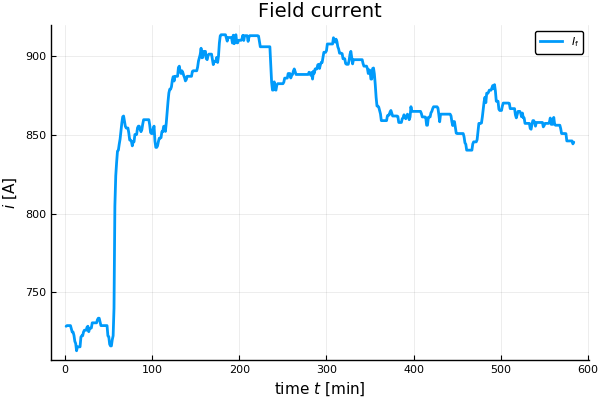

In [5]:
plot(If,lw=LW1,label=L"I_\mathrm{f}")
plot!(xlabel=L"time $t$ [min]", ylabel=L"$i$ [A]",title="Field current")

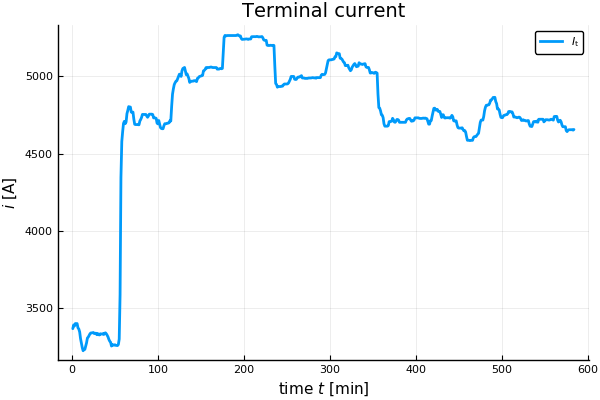

In [6]:
plot(It,lw=LW1,label=L"I_\mathrm{t}")
plot!(xlabel=L"time $t$ [min]", ylabel=L"$i$ [A]", title="Terminal current")

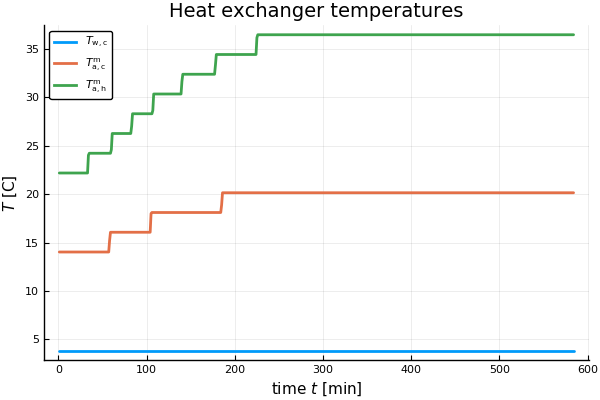

In [7]:
plot(Twc,lw=LW1,label=L"T_\mathrm{w,c}")
plot!(Tac_m,lw=LW1,label=L"T_\mathrm{a,c}^\mathrm{m}")
plot!(Tah_m,lw=LW1,label=L"T_\mathrm{a,h}^\mathrm{m}")
plot!(xlabel=L"time $t$ [min]", ylabel=L"$T$ [C]", title="Heat exchanger temperatures")

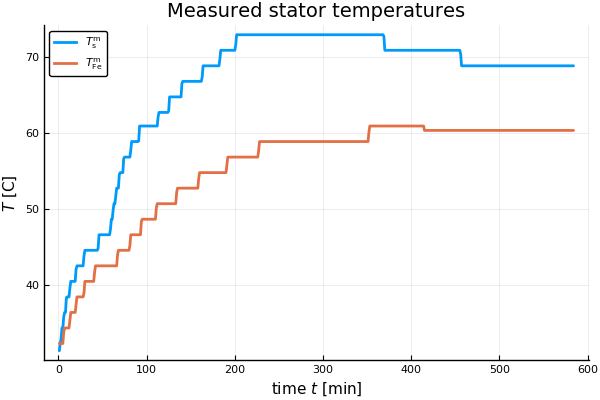

In [8]:
plot(Ts_m,lw=LW1,label=L"T_\mathrm{s}^\mathrm{m}")
plot!(TFe_m,lw=LW1,label=L"T_\mathrm{Fe}^\mathrm{m}")
plot!(xlabel=L"time $t$ [min]", ylabel=L"$T$ [C]", title="Measured stator temperatures")

#### **Simulation model**
#### Inputs

In [9]:
# If, imported from CSV file
# It, imported from CSV file
# Twc, imported from CSV file
QdFes = 212.
Wdf = 528.
Qdfs = 0.8*Wdf # Efficient heating in air gap due to friction
mdw = 48.51
mda = 44.28;

#### Parameters

In [10]:
pa = 1.01e5 # Atmospheric pressure , Pa
#
# Heat capacities
chpa = 1.012#1.15 # Specific heat capacity air , kJ.kg-1.K-1  
chpw = 4.1813#4.2 # Specific heat capacity water , kJ.kg-1.K-1 
chpCu = 0.385#0.385 # Specific heat capacity copper , kJ.kg-1.K -1 
chpFe = 0.412#0.465 # Specific heat capacity iron , kJ.kg-1.K-1 
#
# Metal massses
mr = 9260. # Mass of copper in rotor , kg
ms = 6827. # Mass of copper in stator , kg
mFe = 71200. # Mass of iron in stator , kg
#
# Specific volumes (inverse of density)
VhCu = 0.112e-3 # Specific volume of copper , m3/kg 
VhFe = 0.127e-3 # Specific volume of iron , m3/kg 
#
# Resulting volumes
Vr = mr*VhCu # Rotor copper volume , m3  
Vs = ms*VhCu # Stator copper volume , m3 
VFe = mFe*VhFe # Stator iron volume , m3 
#
# Heat transfer (heat transfer coefficient x area), fluids to solid
hAax = 55.6 # Heat transfer from air to solid, kW/K
hAwx = 222. # Heat transfer from water to solid, kW/K
#
# Overall heat transfer (overall heat transfer coeffcients x area)
UAx = 1/(1/hAax+1/hAwx) # Overall heat transfer air-to-water, kW/K
UAr2d = 2.96 #2.835  #2.7 # Heat transfer, rotor copper to air gap, kW/K 
UAs2Fe = 18 #19.#20. # Heat transfer, stator copper to stator iron, kW/K 
UAFe2a = 12.87 #13.585 # 14.285 # 14.3 # Heat transfer, rotor iron to hot air, kW/K 
#
# Stanton numbers for heat exchanger
NSta = UAx/chpa/(mda)
NStw = UAx/chpw/(mdw)
NStd = NStw - NSta
#
# Enthalpies of formation
Hha_o = 0. # Enthalpy of formation air, kJ/kg
HhCu_o = 0. # Enthalpy of formation copper, kJ/kg 
HhFe_o = 0. # Enthalpy of formation iron, kJ/kg
#
# Standard state temperatures
Ta_o = 25. # Standard state temperature air, C
TCu_o = 25. # Standard state temperature copper, C
TFe_o = 25. # Standard state temperature iron, C
#
# Copper conductor resistances
Rr = 0.127e-3 # Ohmic resistance, rotor copper, kOhm, at 25 C
Rs = 1.95e-6  # Ohmic resistance, stator copper, kOhm, at 25 C
#
# Vector of parameters
par = [pa,chpa,chpw,chpCu,chpFe,mr,ms,mFe,VhCu,VhFe,
    Vr,Vs,VFe,UAr2d,UAs2Fe,UAFe2a,Hha_o,HhCu_o,
    HhFe_o,Ta_o,TCu_o,TFe_o,Rr,Rs,Qdfs,hAax,hAwx,UAx,NStw,NSta,NStd];

#### Models
##### Algebraic variables

In [11]:
# Given x_k = (Tr,Ts,TFe) at time index k,
# this function returns z_k = (Tac,Tad,Tah) at time index k
function z_k(x_k,k)
    Tr,Ts,TFe = x_k
    function f!(F, z)
        Tac,Tad,Tah = z[1], z[2], z[3]
        F[1] = mda*chpa*(Tac-Tad)+UAr2d*(Tr-Tad)+Qdfs
        F[2] = mda*chpa*(Tad-Tah)+UAFe2a*(TFe-Tah)
        F[3] = Tac*(NStw-NSta*exp(-NStd))-NStd*Tah-NSta*(1-exp(-NStd))*Twc[k]
    end
    return nlsolve(f!,[Ta_o,Ta_o,Ta_o]).zero   
end

z_k (generic function with 1 method)

##### One step ahead state predictor

In [12]:
# Given x_k = (Tr,Ts,TFe) at time index k, z_k = (Tac,Tad,Tah) at time index k
# and wx_k at time index k, this function returns x_kp1 at time index k+1
#
# Sample time for measurements
dt = 60 # Discretization time, s
#
# Number nx of states x; number nz of algebraic variables nz
nx = 3
nz = 3
#
# Prediktor, using Explicit Euler
function x_kp1(x_k,z_k,wx_k,k)
    Tr,Ts,TFe = x_k
    Tac,Tad,Tah = z_k
    wTr,wTs,wTFe = wx_k
    #
    # Vector fields
    fTr = (1.1*Rr*If[k]^2-UAr2d*(Tr-Tad))/(mr*chpCu)
    fTs = (3*Rs*It[k]^2-UAs2Fe*(Ts-TFe))/(ms*chpCu)
    fTFe = (UAs2Fe*(Ts-TFe)-UAFe2a*(TFe-Tah)+QdFes)/(mFe*chpFe)
    #
    # Euler integration + addition of discrete state disturbance
    Tr = Tr + dt*fTr + wTr
    Ts = Ts + dt*fTs + wTs
    TFe = TFe + dt*fTFe + wTFe
    return [Tr,Ts,TFe]
end

x_kp1 (generic function with 1 method)

##### Outputs

In [13]:
# Given x_k = (Tr,Ts,TFe), compute output y_k = (Ts,TFe)
function y_k(x_k)
    return x_k[[2,3]]
end

y_k (generic function with 1 method)

#### **Statistical description: state disturbance, noise, and initial value**

In [14]:
#
# Statistical description of state disturbance, measurement noise, and initial state
#
# Process state disturbance covariance W and Process state disturbance standard deviation sW
W = diagm(0=>[2^2,2^2,2^2])
sW = sqrt(W)
#
# Measurement noise covariance V and Measurement noise standard deviation sV
V = diagm(0 => [1^2,1^2])
sV = sqrt(V)
#
# Initial state
x1 = [28.,Ts_m[1],TFe_m[1]]
#
# Initial state covariance X1 and Initial state standard deviation sX1
#
mux = 10;
X1 = mux*W
sX1 = sqrt(X1);

##### Ensemble Kalman Filter

In [15]:
function EnKF(particles)
    # Number of particles np; N measurement data, nx states, nz algebraic variables, ny measurements
    np = particles
    XX_pr = zeros(nx,N,np) # Priori particles
    XX_po = zeros(nx,N,np) # Posteriori particles
    ZZ = zeros(nz,N,np) # Best (posteriori) algebraic particles 
    YY_pr = zeros(ny,N,np) # Priori output particles
    #
    # Initialization
    #
    # Drawing initial state for particles
    XX_po[:,1,:] = kron(x1,ones(1,np)) + sX1*randn(nx,np)
    XX_pr = XX_po
    #
    # Computing initial algebraic variables for particles
    ZZ[:,1,:] = reduce(hcat,[z_k(XX_po[:,1,p],1) for p in 1:np])
    #
    # Computing initial noisy outputs for particles
    YY_pr[:,1,:] = reduce(hcat,[y_k(XX_pr[:,1,p]) for p in 1:np]) + sV*randn(ny,np);
    # Loops over data
    for k in 2:N
        #
        # Predicting states for every particle
        for p in 1:np
            XX_pr[:,k,p] = x_kp1(XX_po[:,k-1,p],ZZ[:,k-1,p],sW*randn(nx),k-1)
        end
        # Predicting outputs for every particle
        YY_pr[:,k,:] = reduce(hcat,[y_k(XX_pr[:,k,p]) for p in 1:np]) + sV*randn(ny,np);
        # Computing Kalman gain
        Z = cov(XX_pr[:,k,:],YY_pr[:,k,:],dims=2)
        E = cov(YY_pr[:,k,:],dims=2)
        K = Z/E
        # Computing posteriori particles
        for p in 1:np
            XX_po[:,k,p] = XX_pr[:,k,p] + K*(y_m[k]- YY_pr[:,k,p])
        end
        # Updating algebraic variables for every particle
        ZZ[:,k,:] = reduce(hcat,[z_k(XX_po[:,k,p],k) for p in 1:np])
    end
    x_pr = mean(XX_pr,dims=3)[:,:,1]
    x_pr_s = std(XX_pr,dims=3)[:,:,1]
    x_po = mean(XX_po,dims=3)[:,:,1]
    x_po_s = std(XX_po,dims=3)[:,:,1]
    z = mean(ZZ,dims=3)[:,:,1]
    z_s = std(ZZ,dims=3)[:,:,1]
    y_pr = mean(YY_pr,dims=3)[:,:,1];
    y_pr_s = std(YY_pr,dims=3)[:,:,1];
    return [x_po,z,y_pr]
end

EnKF (generic function with 1 method)

##### Indices for subsampling measurements

In [16]:
idx = 1:10:N;

#### Unscented Kalman Filter

In [17]:
function UKF()
    # N measurement data, nx states, nz algebraic variables, ny measurements
    xu_pr = zeros(nx,N) # Priori states
    xu_po = zeros(nx,N) # Posteriori states
    zu = zeros(nz,N) # Best (posteriori) algebraic values 
    yu_pr = zeros(ny,N) # Priori output values
    #
    # Standard deviation
    xu_pr_s = zeros(nx,N) # Priori state std
    xu_po_s = zeros(nx,N) # Posteriori states std
    zu_s = zeros(nz,N) # Best (posteriori) algebraic value std 
    yu_pr_s = zeros(ny,N) # Priori output value std
    #
    # Sigma matrices
    XXu_pr = zeros(nx,2*nx)
    XXu_po = zeros(nx,2*nx)
    ZZu = zeros(nz,2*nx)
    YYu_pr = zeros(ny,2*nx)
    #
    # Initialization
    #
    xu_po[:,1] = x1;
    xu_pr[:,1] = x1;
    zu[:,1] = z_k(x1,1)
    yu_pr[:,1] = y_k(x1);
    #
    xu_po_s[:,1] = diag(sqrt(X1))
    xu_pr_s[:,1] = xu_po_s[:,1];
    # Initializing current covariance matrix
    X_po = X1;
    # Loops over data
    for k in 2:N
        #
        # Finding sigma points XXu_po
        XX = cholesky(nx*X_po).L
        XXu_po[:,1:nx] = xu_po[:,k-1] .+ XX
        XXu_po[:,nx+1:2nx] = xu_po[:,k-1] .- XX
        #
        # Finding sigma points ZZu
        for i in 1:2*nx
            ZZu[:,i] = z_k(XXu_po[:,i],k-1)
        end
        #
        # Predicting sigma states XXu_pr and outputs YYu_pr
        for i in 1:2*nx
            wx = zeros(3)
            XXu_pr[:,i] = x_kp1(XXu_po[:,i],ZZu[:,i],wx,k-1)
        end
        for i in 1:2*nx
            YYu_pr[:,i] = y_k(XXu_pr[:,i])
        end
        # Computing Kalman gain
        Z = cov(XXu_pr,YYu_pr,dims=2,corrected=false)
        E = cov(YYu_pr,dims=2,corrected=false) + V
        K = Z/E
        #
        # Computing means over sigma values and posteriori values
        xu_pr[:,k] = mean(XXu_pr,dims=2)
        yu_pr[:,k] = mean(YYu_pr,dims=2)
        xu_po[:,k] = xu_pr[:,k] + K*(y_m[k] - yu_pr[:,k])
        zu[:,k] = z_k(xu_po[:,k],k)
        # Computing covariances
        X_pr = cov(XXu_pr,dims=2,corrected=false) + W
        X_po = Hermitian(X_pr - K*E*K')
        # Computing standard deviations
        xu_pr_s[:,k] = diag(sqrt(X_pr))
        xu_po_s[:,k] = diag(sqrt(X_po))
        yu_pr_s[:,k] = std(YYu_pr,dims=2)
        zu_s[:,k] = std(ZZu,dims=2)
    end
    return [xu_po,zu,yu_pr]
end

UKF (generic function with 1 method)

## Function for Resampling for particle filters

In [18]:
    function resampling_strategy(norm_LH, Np, a_priori_particles, strategy)
        post_particles = zeros(nx,Np)
        roughening=true
        # Parameters for roughening
        Mm = maximum(a_priori_particles)-minimum(a_priori_particles)
        sd = 0.2*Mm*Np^(-1/3)
        if strategy=="Ris04"
            for i in 1:Np
                randNum = rand() # between 0 and 1
                LHAccum = 0.
                for j in 1:Np
                    LHAccum = LHAccum + norm_LH[j]
                    if LHAccum >= randNum
                        if roughening==true
                            post_particles[:,i] = a_priori_particles[:,j]+sd*randn(3)
                        else roughening==false
                            post_particles[:,i] = a_priori_particles[:,j]
                        end
                        break 
                    end
                end
            end
        end
        
        if strategy=="multinomial"
            LHAccum = cumsum(norm_LH)
            j = 1 # This selects likelihood
            orderedNum = sort(rand(Np))
            for i in 1:Np
                while LHAccum[j]<orderedNum[i]
                    j=j+1
                end
                if roughening==true
                        post_particles[:,i] = a_priori_particles[:,j]+sd*randn(3)
                else roughening==false
                        post_particles[:,i] = a_priori_particles[:,j]
                end
            end
        end
    
        if strategy=="systematic"
            LHAccum = cumsum(norm_LH)
            combination = zeros(1,Np+1)
            combination[1:Np] = collect(range(0,stop=1-1/Np,length=Np)) + rand(Np)/Np
            combination[Np+1] = 1.
            j = 1 # This selects likelihood
            i = 1 # This selects apriori particles
            while i<=Np
                if combination[i]<LHAccum[j]
                    if roughening==true
                        post_particles[:,i] = a_priori_particles[:,j]+sd*randn(3)
                    else roughening==false
                        post_particles[:,i] = a_priori_particles[:,j]
                    end
                    i = i+1
                else
                    j = j+1
                end
        
            end
        end
    
        if strategy=="stratified"
            LHAccum = cumsum(norm_LH)
            stf = zeros(1,Np+1)
            orderedNum = rand(Np)/Np
            j = 1:Np
            for (index,value) in enumerate(j)
                stf[index] = orderedNum[index]+(value-1)/Np
            end
            stf[Np+1]=1.
            i = 1
            j = 1
            while i<=Np
                if stf[i]<LHAccum[j]
                   if roughening==true
                        post_particles[:,i] = a_priori_particles[:,j]+sd*randn(3)
                    else roughening==false
                        post_particles[:,i] = a_priori_particles[:,j]
                    end 
                   i=i+1
                else
                   j=j+1 
                end
            end
        end
        
        if strategy=="residual"
            # part-I calculate Modified weights
           # LHAccum = cumsum(norm_LH) # cummulative distribution
            nW1 = floor.(Int,Np*norm_LH) # new weights n'=floor(np*LHAcumm)
            sumnW1 = sum(nW1)
            mod_norm_LH = ((Np*norm_LH)-nW1)/(Np-sumnW1) # modified weights
            LHAccum = cumsum(mod_norm_LH)
            # part-II Use any of the resampling algo. multinominal, stratified or systematic
            # Using multinomianl
            j = 1 # This selects likelihood
            orderedNum = sort(rand(Np))
            for i in 1:Np
                while LHAccum[j]<orderedNum[i]
                    j=j+1
                end
                if roughening==true
                        post_particles[:,i] = a_priori_particles[:,j]+sd*randn(3)
                else roughening==false
                        post_particles[:,i] = a_priori_particles[:,j]
                end
            end
        end
        
        if strategy=="RPF"
            # Initialization for the regularized particle filter.
            d = length(nx); # dimension of the state vector
            c = 2*pi/3; # volume of unit hypersphere in 3-dimensional space
            h = (8 * c^(-1) * (d + 4) * (2 * sqrt(pi))^d)^(1 / (d + 4)) * Np^(-1 / (d + 4)); # bandwidth of regularized filter

           # Compute covariace
            S=cov(a_priori_particles',corrected=false)
            S = Hermitian(S)
            A=cholesky(S)
            Nreg = 5*Np #bins for RPF
            qreg=zeros(Nreg)#likelihood for Reg. Particles
            # Define domain to choose a posteriori particles for RPF
            a_priori_reg = zeros(nx,Nreg)
            a_priori_reg[:,1] = minimum(a_priori_particles,dims=2)-std(a_priori_particles,dims=2)
            a_priori_reg[:,Nreg]=maximum(a_priori_particles,dims=2)-std(a_priori_particles,dims=2)
            dx = (a_priori_reg[:,Nreg]-a_priori_reg[:,1])/(Nreg-1)
            for i in 2:Nreg-1
                a_priori_reg[:,i]=a_priori_reg[:,i-1]+dx
            end
            # Creat pdf aaprox for RPF phat(xk/yk)
            for j in 1:Nreg
                qreg[j]=0
                for i in 1:Np
                    normx = norm(inv(A)*(a_priori_reg[:,j]-a_priori_particles[:,i]))
                    if normx<h
                        qreg[j]=qreg[j]+norm_LH[i]*(d+2)*(1-normx^2/h^2)/2/c/h^d/det(A);
                    end
                end
            end
            # Normalize qreg
            qreg=qreg/sum(qreg)
            # Now resample using any of the resmapling method we choose multinomial
            for i in 1:Np
                randNum = rand() # between 0 and 1
                LHAccum = 0.
                for j in 1:Nreg
                    LHAccum = LHAccum + qreg[j]
                    if LHAccum >= randNum
                        if roughening==true
                            post_particles[:,i] = a_priori_reg[:,j]+sd*randn(3)
                        else roughening==false
                            post_particles[:,i] = a_priori_reg[:,j]
                        end
                        break 
                    end
                end
            end
        end
        
        if strategy=="APF"
            alpha=1.1
            norm_LH_tilde = [((alpha-1)*norm_LH[i]+mean(norm_LH))/alpha for i in 1:Np]
            # Resampling using any algorithm we use multinominal
            LHAccum = cumsum(norm_LH_tilde)
            j = 1 # This selects likelihood
            orderedNum = sort(rand(Np))
            for i in 1:Np
                while LHAccum[j]<orderedNum[i]
                    j=j+1
                end
                if roughening==true
                        post_particles[:,i] = a_priori_particles[:,j]+sd*randn(3)
                else roughening==false
                        post_particles[:,i] = a_priori_particles[:,j]
                end
            end
        end
    
        return post_particles
    end


resampling_strategy (generic function with 1 method)

In [19]:
# Particle filter algorithm
function PF(particles,strategy)
    # Particle filters
    # Storing array and initializations
    # Number of particles np; N measurement data, nx states, nz algebraic variables, ny measurements
    np = particles
    XX_pr = zeros(nx,N,np) # Priori particles
    XX_po = zeros(nx,N,np) # Posteriori particles
    ZZ = zeros(nz,N,np) # Best (posteriori) algebraic particles 
    YY_pr = zeros(ny,N,np) # Priori output particles
    LH = zeros(1,N,np) # Likelihood
    #
    # Initialization
    #
    # Drawing initial state for particles
    XX_po[:,1,:] = kron(x1,ones(1,np)) + sX1*randn(nx,np)
    XX_pr = XX_po
    #
    # Computing initial algebraic variables for particles
    ZZ[:,1,:] = reduce(hcat,[z_k(XX_po[:,1,p],1) for p in 1:np])
    #
    # Computing initial noisy outputs for particles
    YY_pr[:,1,:] = reduce(hcat,[y_k(XX_pr[:,1,p]) for p in 1:np]) + sV*randn(ny,np);
    #
    # Computing initial likelihood
    for p in 1:np
        IInnv = y_m[1]-YY_pr[:,1,p]
        LH[1,1,p] = 1/((2*3.14)^2/2)/sqrt(det(V))*exp(-IInnv'*inv(V)*IInnv/2)
    end
    np = particles
    for k in 2:N
        # predicting states for every particles
        # -- a priori --
        for p in 1:np
            XX_pr[:,k,p] = x_kp1(XX_po[:,k-1,p],ZZ[:,k-1,p],sW*randn(nx),k-1)
        end
        # Predicting outputs for every particle
        YY_pr[:,k,:] = reduce(hcat,[y_k(XX_pr[:,k,p]) for p in 1:np]) + sV*randn(ny,np);
        # Computing Likelihood of each particles conditioned on measurement y_m
        for p in 1:np
            Innv = y_m[k]- YY_pr[:,k,p]
            LH[1,k,p] = 1/((2*3.14)^2/2)/sqrt(det(V))*exp(-Innv'*inv(V)*Innv/2)
        end
        # Normalizing the likelihood of a priori estimates 
        LH[1,k,:] = LH[1,k,:]/sum(LH[1,k,:])
        # Posteriori particle--resampling
        # page 467, dan simon optimal state estimation
        XX_po[:,k,:] = resampling_strategy(LH[1,k,:],np,XX_pr[:,k,:],strategy)
        # Updating algebraic variables for every particle
        ZZ[:,k,:] = reduce(hcat,[z_k(XX_po[:,k,p],k) for p in 1:np])
    end
    # Mean and standard deviations
    x_pr = mean(XX_pr,dims=3)[:,:,1]
    x_pr_s = std(XX_pr,dims=3)[:,:,1]
    x_po = mean(XX_po,dims=3)[:,:,1]
    x_po_s = std(XX_po,dims=3)[:,:,1]
    z = mean(ZZ,dims=3)[:,:,1]
    z_s = std(ZZ,dims=3)[:,:,1]
    y_pr = mean(YY_pr,dims=3)[:,:,1];
    y_pr_s = std(YY_pr,dims=3)[:,:,1];
    return  [x_po,z,y_pr]
end

PF (generic function with 1 method)

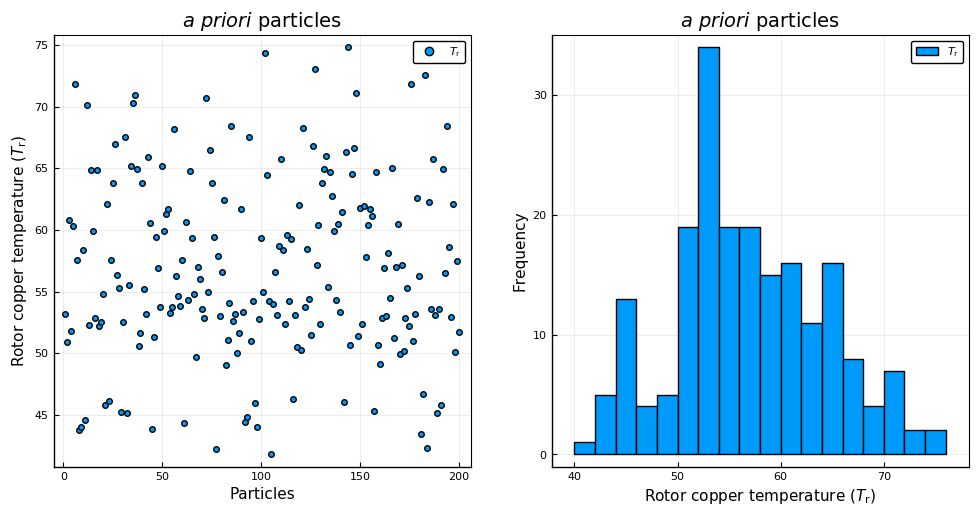

In [222]:
# Plotting apriori particles
pyplot();
figpath = "C:/Users/pande/Desktop/Desktop/SummerJob2019/Figures/Resampling";
using Plots.PlotMeasures
aprioriHistogram=histogram(XX_pr[1,500,:],nbins=20,title="\$a\\ priori\$ particles",xlabel="Rotor copper temperature (\$T_\\mathrm{r}\$)",
    ylabel="Frequency",framestyle="box",label="\$T_\\mathrm{r}\$",size=(550,550))
aprioriParticles=histogram(XX_pr[1,500,:],st=:scatter,nbins=20,title="\$a\\ priori\$ particles",ylabel="Rotor copper temperature (\$T_\\mathrm{r}\$)",
    xlabel="Particles",framestyle="box",label="\$T_\\mathrm{r}\$",size=(550,550))
using Plots.PlotMeasures
resamplingComparison=plot(aprioriParticles,aprioriHistogram,
        layout=grid(1,2),size = (1000, 500),framestyle = :box,
        left_margin=10mm,legend=:topright)
figfile="aprioriparticles.svg"
savefig(figpath*figfile)

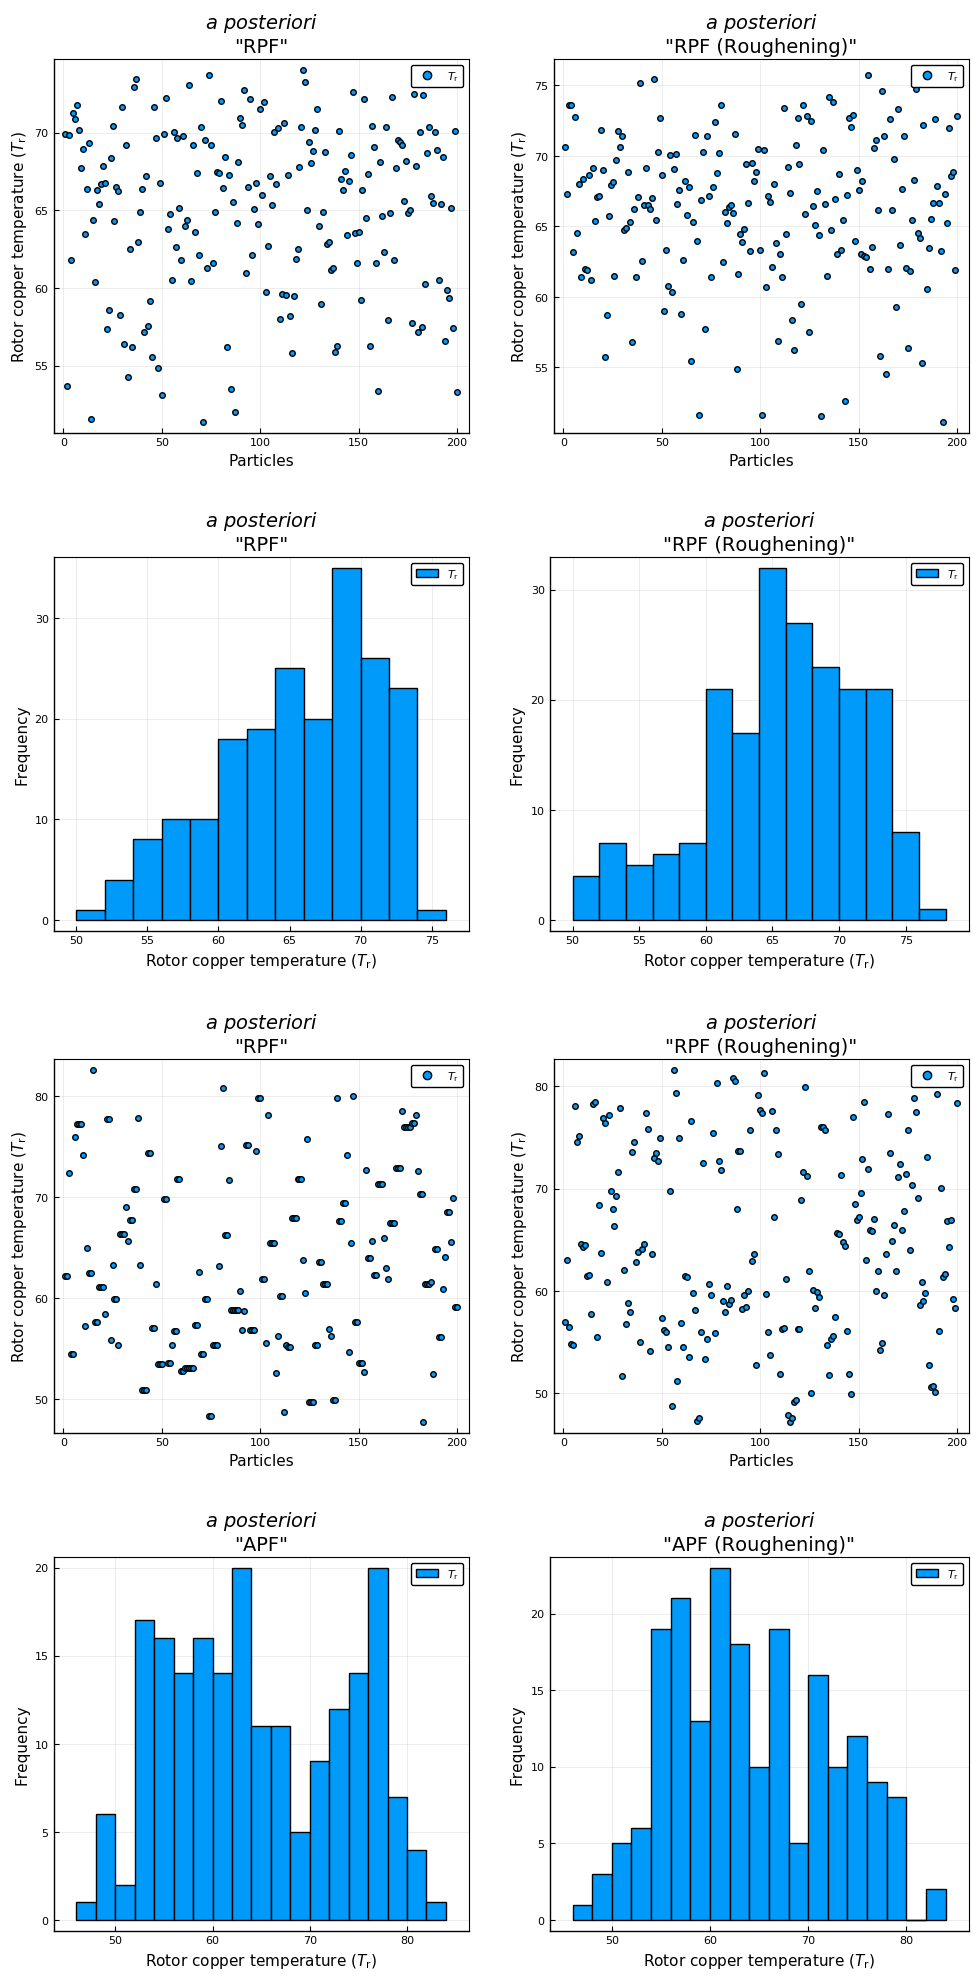

In [360]:
# For RPF and APF

# Plotting clusturing of particles
post_particles = resampling_strategy(LH[1,500,:],np,XX_pr[:,500,:],"RPF",false)
RPFclus=histogram(post_particles[1,:],st=:scatter,nbins=20,title="\$a\\ posteriori\$ \n\"RPF\"",
    ylabel="Rotor copper temperature (\$T_\\mathrm{r}\$)",xlabel="Particles",framestyle="box",label="\$T_\\mathrm{r}\$",size=(550,550));

post_particles = resampling_strategy(LH[1,500,:],np,XX_pr[:,500,:],"RPF",true)
RPFRouclus=histogram(post_particles[1,:],st=:scatter,nbins=20,title="\$a\\ posteriori\$ \n\"RPF (Roughening)\"",
    ylabel="Rotor copper temperature (\$T_\\mathrm{r}\$)",xlabel="Particles",framestyle="box",label="\$T_\\mathrm{r}\$",size=(550,550));

post_particles = resampling_strategy(LH[1,500,:],np,XX_pr[:,500,:],"APF",false)
APFclus=histogram(post_particles[1,:],st=:scatter,nbins=20,title="\$a\\ posteriori\$ \n\"RPF\"",
    ylabel="Rotor copper temperature (\$T_\\mathrm{r}\$)",xlabel="Particles",framestyle="box",label="\$T_\\mathrm{r}\$",size=(550,550));

post_particles = resampling_strategy(LH[1,500,:],np,XX_pr[:,500,:],"APF",true)
APFRouclus=histogram(post_particles[1,:],st=:scatter,nbins=20,title="\$a\\ posteriori\$ \n\"RPF (Roughening)\"",
    ylabel="Rotor copper temperature (\$T_\\mathrm{r}\$)",xlabel="Particles",framestyle="box",label="\$T_\\mathrm{r}\$",size=(550,550));

# Plotting histogram
post_particles = resampling_strategy(LH[1,500,:],np,XX_pr[:,500,:],"RPF",false)
RPF=histogram(post_particles[1,:],nbins=20,title="\$a\\ posteriori\$ \n\"RPF\"",
    xlabel="Rotor copper temperature (\$T_\\mathrm{r}\$)",ylabel="Frequency",framestyle="box",label="\$T_\\mathrm{r}\$",size=(550,550));

post_particles = resampling_strategy(LH[1,500,:],np,XX_pr[:,500,:],"RPF",true)
RPFRou=histogram(post_particles[1,:],nbins=20,title="\$a\\ posteriori\$ \n\"RPF (Roughening)\"",
    xlabel="Rotor copper temperature (\$T_\\mathrm{r}\$)",ylabel="Frequency",framestyle="box",label="\$T_\\mathrm{r}\$",size=(550,550));

post_particles = resampling_strategy(LH[1,500,:],np,XX_pr[:,500,:],"APF",false)
APF=histogram(post_particles[1,:],nbins=20,title="\$a\\ posteriori\$ \n\"APF\"",
    xlabel="Rotor copper temperature (\$T_\\mathrm{r}\$)",ylabel="Frequency",framestyle="box",label="\$T_\\mathrm{r}\$",size=(550,550));

post_particles = resampling_strategy(LH[1,500,:],np,XX_pr[:,500,:],"APF",true)
APFRou=histogram(post_particles[1,:],nbins=20,title="\$a\\ posteriori\$ \n\"APF (Roughening)\"",
    xlabel="Rotor copper temperature (\$T_\\mathrm{r}\$)",ylabel="Frequency",framestyle="box",label="\$T_\\mathrm{r}\$",size=(550,550))

# Plotting
using Plots.PlotMeasures
pyplot();
resamplingComparison=plot(RPFclus,RPFRouclus,RPF,RPFRou,APFclus,APFRouclus,APF,APFRou,
        layout=grid(4,2),size = (1000, 2000),framestyle = :box,
        right_margin=10mm,bottom_margin=10mm,legend=:topright)
figfile="RPFAPFcomparison.svg"
savefig(figpath*figfile)



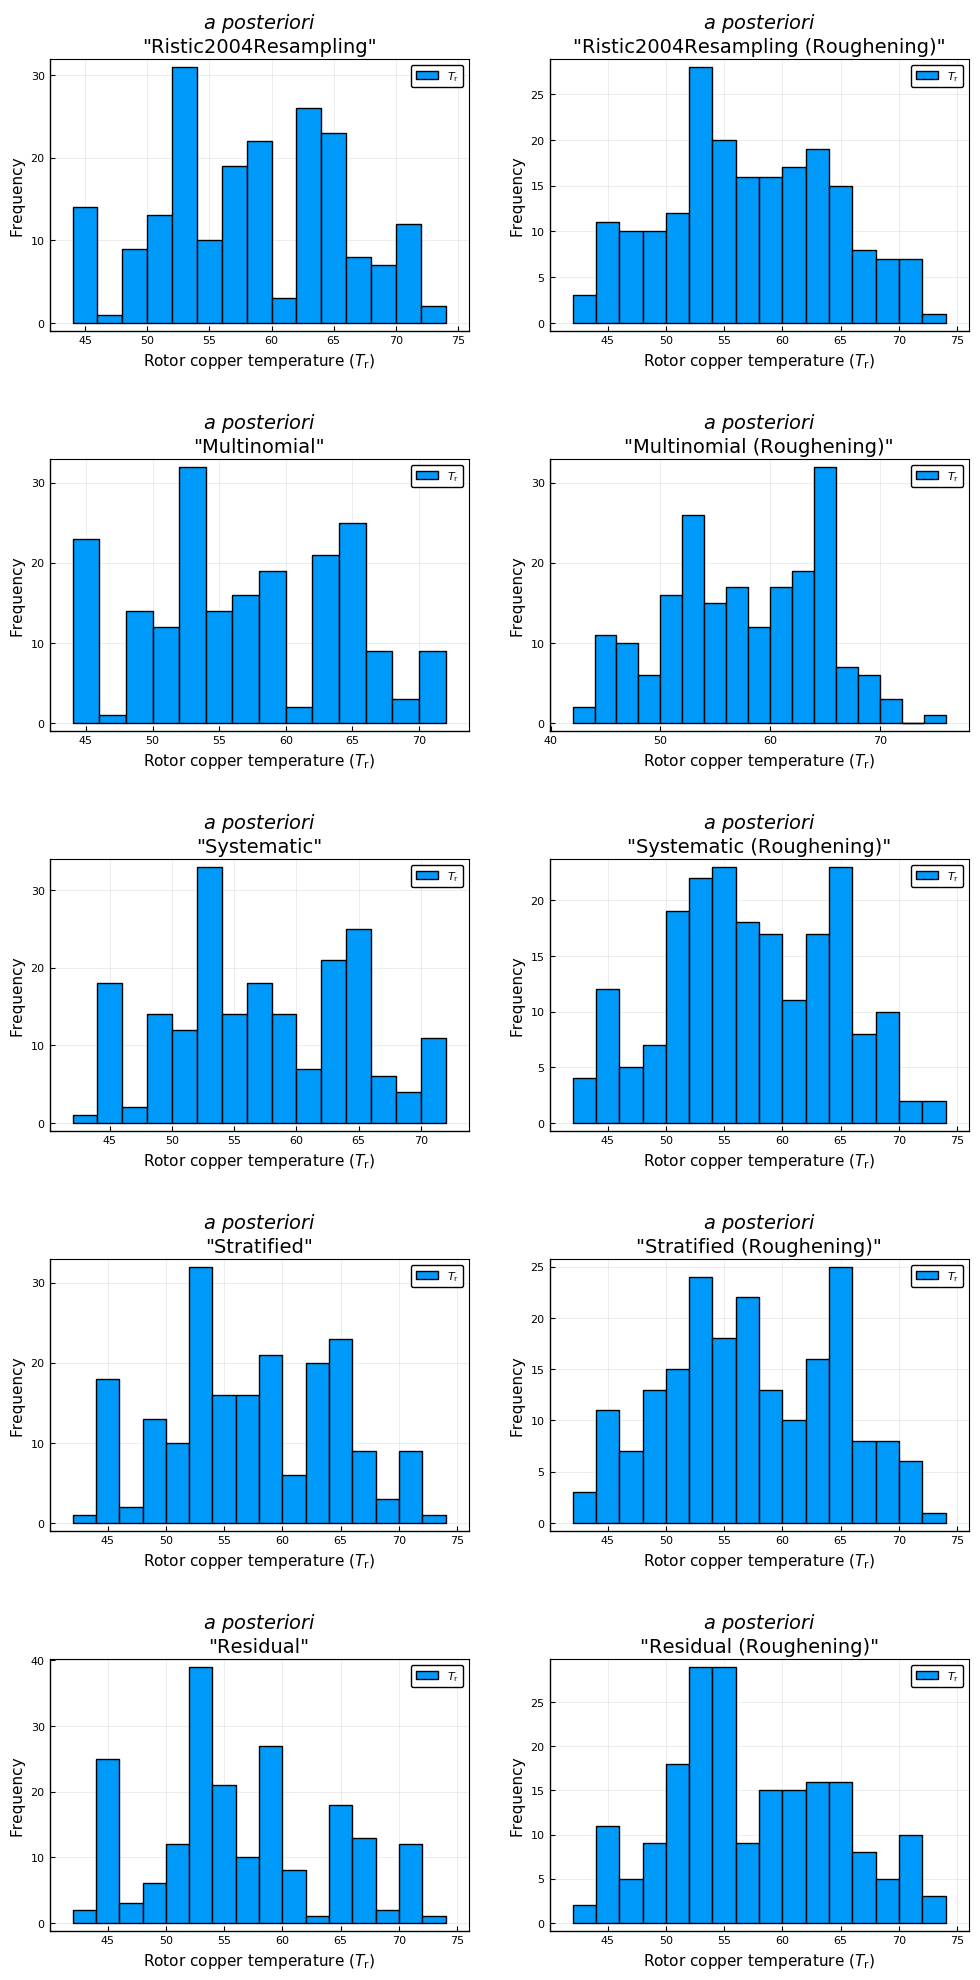

In [226]:
# Plotting resampling histogram of particles
post_particles = resampling_strategy(LH[1,500,:],np,XX_pr[:,500,:],"Ris04",false)
ris04=histogram(post_particles[1,:],nbins=20,title="\$a\\ posteriori\$ \n\"Ristic2004Resampling\"",
    xlabel="Rotor copper temperature (\$T_\\mathrm{r}\$)",ylabel="Frequency",framestyle="box",label="\$T_\\mathrm{r}\$",size=(550,550));

post_particles = resampling_strategy(LH[1,500,:],np,XX_pr[:,500,:],"Ris04",true)
ris04Rou=histogram(post_particles[1,:],nbins=20,title="\$a\\ posteriori\$ \n\"Ristic2004Resampling (Roughening)\"",
    xlabel="Rotor copper temperature (\$T_\\mathrm{r}\$)",ylabel="Frequency",framestyle="box",label="\$T_\\mathrm{r}\$",size=(550,550));

post_particles = resampling_strategy(LH[1,500,:],np,XX_pr[:,500,:],"multinomial",false)
multinomial=histogram(post_particles[1,:],nbins=20,title="\$a\\ posteriori\$ \n\"Multinomial\"",
    xlabel="Rotor copper temperature (\$T_\\mathrm{r}\$)",ylabel="Frequency",framestyle="box",label="\$T_\\mathrm{r}\$",size=(550,550));

post_particles = resampling_strategy(LH[1,500,:],np,XX_pr[:,500,:],"multinomial",true)
multinomialRou=histogram(post_particles[1,:],nbins=20,title="\$a\\ posteriori\$ \n\"Multinomial (Roughening)\"",
    xlabel="Rotor copper temperature (\$T_\\mathrm{r}\$)",ylabel="Frequency",framestyle="box",label="\$T_\\mathrm{r}\$",size=(550,550));

post_particles = resampling_strategy(LH[1,500,:],np,XX_pr[:,500,:],"systematic",false)
systematic=histogram(post_particles[1,:],nbins=20,title="\$a\\ posteriori\$ \n\"Systematic\"",
    xlabel="Rotor copper temperature (\$T_\\mathrm{r}\$)",ylabel="Frequency",framestyle="box",label="\$T_\\mathrm{r}\$",size=(550,550));

post_particles = resampling_strategy(LH[1,500,:],np,XX_pr[:,500,:],"systematic",true)
systematicRou=histogram(post_particles[1,:],nbins=20,title="\$a\\ posteriori\$ \n\"Systematic (Roughening)\"",
    xlabel="Rotor copper temperature (\$T_\\mathrm{r}\$)",ylabel="Frequency",framestyle="box",label="\$T_\\mathrm{r}\$",size=(550,550));

post_particles = resampling_strategy(LH[1,500,:],np,XX_pr[:,500,:],"stratified",false)
stratified=histogram(post_particles[1,:],nbins=20,title="\$a\\ posteriori\$ \n\"Stratified\"",
    xlabel="Rotor copper temperature (\$T_\\mathrm{r}\$)",ylabel="Frequency",framestyle="box",label="\$T_\\mathrm{r}\$",size=(550,550));

post_particles = resampling_strategy(LH[1,500,:],np,XX_pr[:,500,:],"stratified",true)
stratifiedRou=histogram(post_particles[1,:],nbins=20,title="\$a\\ posteriori\$ \n\"Stratified (Roughening)\"",
    xlabel="Rotor copper temperature (\$T_\\mathrm{r}\$)",ylabel="Frequency",framestyle="box",label="\$T_\\mathrm{r}\$",size=(550,550));

post_particles = resampling_strategy(LH[1,500,:],np,XX_pr[:,500,:],"residual",false)
residual=histogram(post_particles[1,:],nbins=20,title="\$a\\ posteriori\$ \n\"Residual\"",
    xlabel="Rotor copper temperature (\$T_\\mathrm{r}\$)",ylabel="Frequency",framestyle="box",label="\$T_\\mathrm{r}\$",size=(550,550));

post_particles = resampling_strategy(LH[1,500,:],np,XX_pr[:,500,:],"residual",true)
residualRou=histogram(post_particles[1,:],nbins=20,title="\$a\\ posteriori\$ \n\"Residual (Roughening)\"",
    xlabel="Rotor copper temperature (\$T_\\mathrm{r}\$)",ylabel="Frequency",framestyle="box",label="\$T_\\mathrm{r}\$",size=(550,550));
# Plotting for SummerJob2019
figpath = "C:/Users/pande/Desktop/Desktop/SummerJob2019/Figures/Resampling";
using Plots.PlotMeasures
pyplot();
resamplingComparison=plot(ris04,ris04Rou,multinomial,multinomialRou,systematic,systematicRou,
    stratified,stratifiedRou,residual,residualRou,
        layout=grid(5,2),size = (1000, 2000),framestyle = :box,
        right_margin=10mm,bottom_margin=10mm,legend=:topright)
figfile="resamplingcomparisonHistogram.svg"
savefig(figpath*figfile)

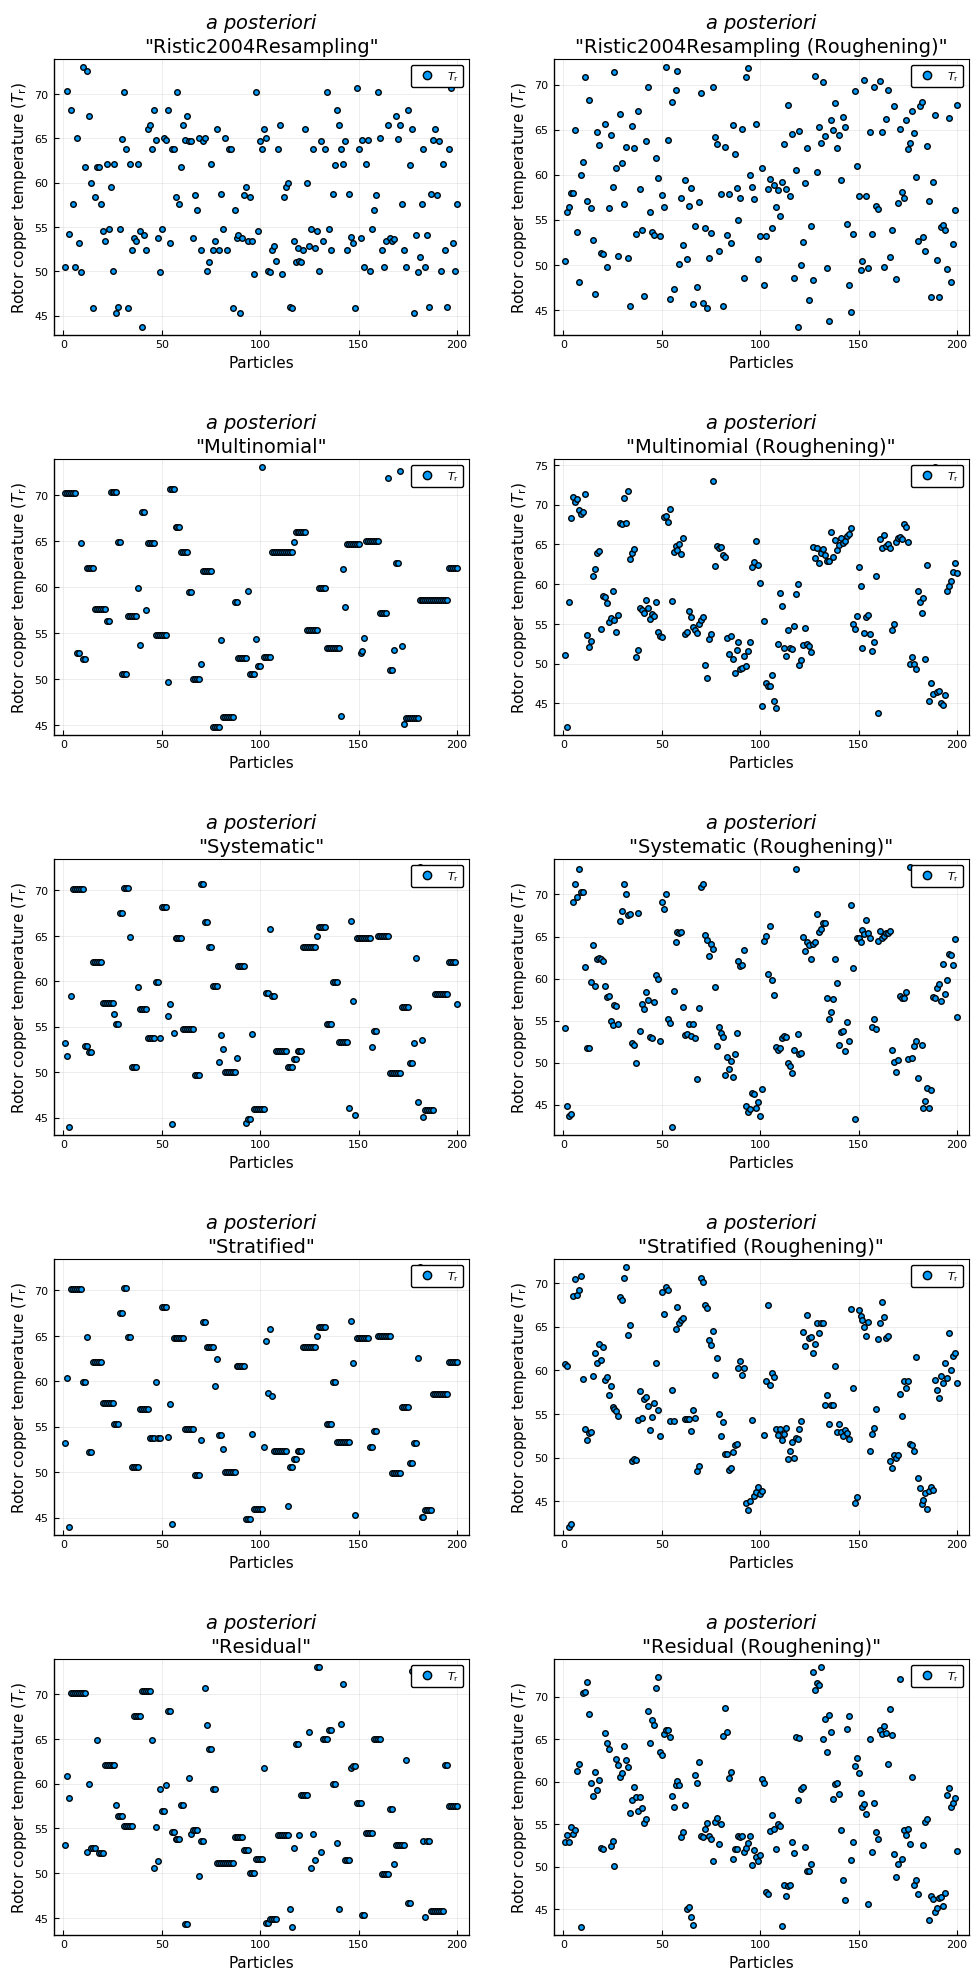

In [228]:
# Plotting clusturing of particles
post_particles = resampling_strategy(LH[1,500,:],np,XX_pr[:,500,:],"Ris04",false)
ris04=histogram(post_particles[1,:],st=:scatter,nbins=20,title="\$a\\ posteriori\$ \n\"Ristic2004Resampling\"",
    ylabel="Rotor copper temperature (\$T_\\mathrm{r}\$)",xlabel="Particles",framestyle="box",label="\$T_\\mathrm{r}\$",size=(550,550));

post_particles = resampling_strategy(LH[1,500,:],np,XX_pr[:,500,:],"Ris04",true)
ris04Rou=histogram(post_particles[1,:],st=:scatter,nbins=20,title="\$a\\ posteriori\$ \n\"Ristic2004Resampling (Roughening)\"",
    ylabel="Rotor copper temperature (\$T_\\mathrm{r}\$)",xlabel="Particles",framestyle="box",label="\$T_\\mathrm{r}\$",size=(550,550));

post_particles = resampling_strategy(LH[1,500,:],np,XX_pr[:,500,:],"multinomial",false)
multinomial=histogram(post_particles[1,:],st=:scatter,nbins=20,title="\$a\\ posteriori\$ \n\"Multinomial\"",
    ylabel="Rotor copper temperature (\$T_\\mathrm{r}\$)",xlabel="Particles",framestyle="box",label="\$T_\\mathrm{r}\$",size=(550,550));

post_particles = resampling_strategy(LH[1,500,:],np,XX_pr[:,500,:],"multinomial",true)
multinomialRou=histogram(post_particles[1,:],st=:scatter,nbins=20,title="\$a\\ posteriori\$ \n\"Multinomial (Roughening)\"",
    ylabel="Rotor copper temperature (\$T_\\mathrm{r}\$)",xlabel="Particles",framestyle="box",label="\$T_\\mathrm{r}\$",size=(550,550));

post_particles = resampling_strategy(LH[1,500,:],np,XX_pr[:,500,:],"systematic",false)
systematic=histogram(post_particles[1,:],st=:scatter,nbins=20,title="\$a\\ posteriori\$ \n\"Systematic\"",
    ylabel="Rotor copper temperature (\$T_\\mathrm{r}\$)",xlabel="Particles",framestyle="box",label="\$T_\\mathrm{r}\$",size=(550,550));

post_particles = resampling_strategy(LH[1,500,:],np,XX_pr[:,500,:],"systematic",true)
systematicRou=histogram(post_particles[1,:],st=:scatter,nbins=20,title="\$a\\ posteriori\$ \n\"Systematic (Roughening)\"",
    ylabel="Rotor copper temperature (\$T_\\mathrm{r}\$)",xlabel="Particles",framestyle="box",label="\$T_\\mathrm{r}\$",size=(550,550));

post_particles = resampling_strategy(LH[1,500,:],np,XX_pr[:,500,:],"stratified",false)
stratified=histogram(post_particles[1,:],st=:scatter,nbins=20,title="\$a\\ posteriori\$ \n\"Stratified\"",
    ylabel="Rotor copper temperature (\$T_\\mathrm{r}\$)",xlabel="Particles",framestyle="box",label="\$T_\\mathrm{r}\$",size=(550,550));

post_particles = resampling_strategy(LH[1,500,:],np,XX_pr[:,500,:],"stratified",true)
stratifiedRou=histogram(post_particles[1,:],st=:scatter,nbins=20,title="\$a\\ posteriori\$ \n\"Stratified (Roughening)\"",
    ylabel="Rotor copper temperature (\$T_\\mathrm{r}\$)",xlabel="Particles",framestyle="box",label="\$T_\\mathrm{r}\$",size=(550,550));

post_particles = resampling_strategy(LH[1,500,:],np,XX_pr[:,500,:],"residual",false)
residual=histogram(post_particles[1,:],st=:scatter,nbins=20,title="\$a\\ posteriori\$ \n\"Residual\"",
    ylabel="Rotor copper temperature (\$T_\\mathrm{r}\$)",xlabel="Particles",framestyle="box",label="\$T_\\mathrm{r}\$",size=(550,550));

post_particles = resampling_strategy(LH[1,500,:],np,XX_pr[:,500,:],"residual",true)
residualRou=histogram(post_particles[1,:],st=:scatter,nbins=20,title="\$a\\ posteriori\$ \n\"Residual (Roughening)\"",
    ylabel="Rotor copper temperature (\$T_\\mathrm{r}\$)",xlabel="Particles",framestyle="box",label="\$T_\\mathrm{r}\$",size=(550,550));
# Plotting for SummerJob2019
figpath = "C:/Users/pande/Desktop/Desktop/SummerJob2019/Figures/Resampling";
using Plots.PlotMeasures
pyplot();
resamplingComparison=plot(ris04,ris04Rou,multinomial,multinomialRou,systematic,systematicRou,
    stratified,stratifiedRou,residual,residualRou,
        layout=grid(5,2),size = (1000, 2000),framestyle = :box,
        bottom_margin=10mm,right_margin=10mm,legend=:topright)
figfile="resamplingcomparisonScatter.svg"
savefig(figpath*figfile)

In [395]:
# Comparing particle filters with different resampling with EnKF and UKF

# Calling UKF
xu_po_UKF,zu_UKF,yu_pr_UKF=UKF();
# Calling EnKF
xu_po_EnKF50,zu_EnKF50,yu_pr_EnKF50=EnKF(50)
xu_po_EnKF100,zu_EnKF100,yu_pr_EnKF100=EnKF(100)
xu_po_EnKF500,zu_EnKF500,yu_pr_EnKF500=EnKF(500)
xu_po_EnKF1000,zu_EnKF1000,yu_pr_EnKF1000=EnKF(1000);

# calling PFRis04
xu_po_PFRis0450,zu_PFRis0450,yu_pr_PFRis0450=PF(50,"Ris04")
xu_po_PFRis04100,zu_PFRis04100,yu_pr_PFRis04100=PF(100,"Ris04")
xu_po_PFRis04500,zu_PFRis04500,yu_pr_PFRis04500=PF(500,"Ris04")
xu_po_PFRis041000,zu_PFRis041000,yu_pr_PFRis041000=PF(1000,"Ris04");

# calling PFmultinomial
xu_po_PFmultinomial50,zu_PFmultinomial50,yu_pr_PFmultinomial50=PF(50,"multinomial")
xu_po_PFmultinomial100,zu_PFmultinomial100,yu_pr_PFmultinomial100=PF(100,"multinomial")
xu_po_PFmultinomial500,zu_PFmultinomial500,yu_pr_PFmultinomial500=PF(500,"multinomial")
xu_po_PFmultinomial1000,zu_PFmultinomial1000,yu_pr_PFmultinomial1000=PF(1000,"multinomial");

# calling PFsystematic
xu_po_PFsystematic50,zu_PFsystematic50,yu_pr_PFsystematic50=PF(50,"systematic")
xu_po_PFsystematic100,zu_PFsystematic100,yu_pr_PFsystematic100=PF(100,"systematic")
xu_po_PFsystematic500,zu_PFsystematic500,yu_pr_PFsystematic500=PF(500,"systematic")
xu_po_PFsystematic1000,zu_PFsystematic1000,yu_pr_PFsystematic1000=PF(1000,"systematic");

# calling PFstratified
xu_po_PFstratified50,zu_PFstratified50,yu_pr_PFstratified50=PF(50,"stratified")
xu_po_PFstratified100,zu_PFstratified100,yu_pr_PFstratified100=PF(100,"stratified")
xu_po_PFstratified500,zu_PFstratified500,yu_pr_PFstratified500=PF(500,"stratified")
xu_po_PFstratified1000,zu_PFstratified1000,yu_pr_PFstratified1000=PF(1000,"stratified");

# calling PFresidual
xu_po_PFresidual50,zu_PFresidual50,yu_pr_PFresidual50=PF(50,"residual")
xu_po_PFresidual100,zu_PFresidual100,yu_pr_PFresidual100=PF(100,"residual")
xu_po_PFresidual500,zu_PFresidual500,yu_pr_PFresidual500=PF(500,"residual")
xu_po_PFresidual1000,zu_PFresidual1000,yu_pr_PFresidual1000=PF(1000,"residual");

# calling PFRPF
xu_po_PFRPF50,zu_PFRPF50,yu_pr_PFRPF50=PF(50,"RPF")
xu_po_PFRPF100,zu_PFRPF100,yu_pr_PFRPF100=PF(100,"RPF")
xu_po_PFRPF500,zu_PFRPF500,yu_pr_PFRPF500=PF(500,"RPF")
xu_po_PFRPF1000,zu_PFRPF1000,yu_pr_PFRPF1000=PF(1000,"RPF");

# calling PFAPF
xu_po_PFAPF50,zu_PFAPF50,yu_pr_PFAPF50=PF(50,"APF")
xu_po_PFAPF100,zu_PFAPF100,yu_pr_PFAPF100=PF(100,"APF")
xu_po_PFAPF500,zu_PFAPF500,yu_pr_PFAPF500=PF(500,"APF")
xu_po_PFAPF1000,zu_PFAPF1000,yu_pr_PFAPF1000=PF(1000,"APF");

In [396]:
# Saving dictionary to a file and opening later for plotting using JLD package
Model1Filters=[xu_po_UKF,zu_UKF,yu_pr_UKF,
xu_po_EnKF50,zu_EnKF50,yu_pr_EnKF50,
xu_po_EnKF100,zu_EnKF100,yu_pr_EnKF100,
xu_po_EnKF500,zu_EnKF500,yu_pr_EnKF500,
xu_po_EnKF1000,zu_EnKF1000,yu_pr_EnKF1000,
xu_po_PFRis0450,zu_PFRis0450,yu_pr_PFRis0450,
xu_po_PFRis04100,zu_PFRis04100,yu_pr_PFRis04100,
xu_po_PFRis04500,zu_PFRis04500,yu_pr_PFRis04500,
xu_po_PFRis041000,zu_PFRis041000,yu_pr_PFRis041000,
xu_po_PFmultinomial50,zu_PFmultinomial50,yu_pr_PFmultinomial50,
xu_po_PFmultinomial100,zu_PFmultinomial100,yu_pr_PFmultinomial100,
xu_po_PFmultinomial500,zu_PFmultinomial500,yu_pr_PFmultinomial500,
xu_po_PFmultinomial1000,zu_PFmultinomial1000,yu_pr_PFmultinomial1000,
xu_po_PFsystematic50,zu_PFsystematic50,yu_pr_PFsystematic50,
xu_po_PFsystematic100,zu_PFsystematic100,yu_pr_PFsystematic100,
xu_po_PFsystematic500,zu_PFsystematic500,yu_pr_PFsystematic500,
xu_po_PFsystematic1000,zu_PFsystematic1000,yu_pr_PFsystematic1000,
xu_po_PFstratified50,zu_PFstratified50,yu_pr_PFstratified50,
xu_po_PFstratified100,zu_PFstratified100,yu_pr_PFstratified100,
xu_po_PFstratified500,zu_PFstratified500,yu_pr_PFstratified500,
xu_po_PFstratified1000,zu_PFstratified1000,yu_pr_PFstratified1000,
xu_po_PFresidual50,zu_PFresidual50,yu_pr_PFresidual50,
xu_po_PFresidual100,zu_PFresidual100,yu_pr_PFresidual100,
xu_po_PFresidual500,zu_PFresidual500,yu_pr_PFresidual500,
xu_po_PFresidual1000,zu_PFresidual1000,yu_pr_PFresidual1000,
xu_po_PFRPF50,zu_PFRPF50,yu_pr_PFRPF50,
xu_po_PFRPF100,zu_PFRPF100,yu_pr_PFRPF100,
xu_po_PFRPF500,zu_PFRPF500,yu_pr_PFRPF500,
xu_po_PFRPF1000,zu_PFRPF1000,yu_pr_PFRPF1000,
xu_po_PFAPF50,zu_PFAPF50,yu_pr_PFAPF50,
xu_po_PFAPF100,zu_PFAPF100,yu_pr_PFAPF100,
xu_po_PFAPF500,zu_PFAPF500,yu_pr_PFAPF500,
xu_po_PFAPF1000,zu_PFAPF1000,yu_pr_PFAPF1000]

# Saving Model 1 for plotting and comparing
# Saves .jld file in same directory
using JLD
save("Model1Filters.jld","Model1Filters",Model1Filters)

In [20]:
Model1Filters=load("Model1Filters.jld")
# Unpacking dicitionary
# Model 1
xu_po_UKF,zu_UKF,yu_pr_UKF,
xu_po_EnKF50,zu_EnKF50,yu_pr_EnKF50,
xu_po_EnKF100,zu_EnKF100,yu_pr_EnKF100,
xu_po_EnKF500,zu_EnKF500,yu_pr_EnKF500,
xu_po_EnKF1000,zu_EnKF1000,yu_pr_EnKF1000,
xu_po_PFRis0450,zu_PFRis0450,yu_pr_PFRis0450,
xu_po_PFRis04100,zu_PFRis04100,yu_pr_PFRis04100,
xu_po_PFRis04500,zu_PFRis04500,yu_pr_PFRis04500,
xu_po_PFRis041000,zu_PFRis041000,yu_pr_PFRis041000,
xu_po_PFmultinomial50,zu_PFmultinomial50,yu_pr_PFmultinomial50,
xu_po_PFmultinomial100,zu_PFmultinomial100,yu_pr_PFmultinomial100,
xu_po_PFmultinomial500,zu_PFmultinomial500,yu_pr_PFmultinomial500,
xu_po_PFmultinomial1000,zu_PFmultinomial1000,yu_pr_PFmultinomial1000,
xu_po_PFsystematic50,zu_PFsystematic50,yu_pr_PFsystematic50,
xu_po_PFsystematic100,zu_PFsystematic100,yu_pr_PFsystematic100,
xu_po_PFsystematic500,zu_PFsystematic500,yu_pr_PFsystematic500,
xu_po_PFsystematic1000,zu_PFsystematic1000,yu_pr_PFsystematic1000,
xu_po_PFstratified50,zu_PFstratified50,yu_pr_PFstratified50,
xu_po_PFstratified100,zu_PFstratified100,yu_pr_PFstratified100,
xu_po_PFstratified500,zu_PFstratified500,yu_pr_PFstratified500,
xu_po_PFstratified1000,zu_PFstratified1000,yu_pr_PFstratified1000,
xu_po_PFresidual50,zu_PFresidual50,yu_pr_PFresidual50,
xu_po_PFresidual100,zu_PFresidual100,yu_pr_PFresidual100,
xu_po_PFresidual500,zu_PFresidual500,yu_pr_PFresidual500,
xu_po_PFresidual1000,zu_PFresidual1000,yu_pr_PFresidual1000,
xu_po_PFRPF50,zu_PFRPF50,yu_pr_PFRPF50,
xu_po_PFRPF100,zu_PFRPF100,yu_pr_PFRPF100,
xu_po_PFRPF500,zu_PFRPF500,yu_pr_PFRPF500,
xu_po_PFRPF1000,zu_PFRPF1000,yu_pr_PFRPF1000,
xu_po_PFAPF50,zu_PFAPF50,yu_pr_PFAPF50,
xu_po_PFAPF100,zu_PFAPF100,yu_pr_PFAPF100,
xu_po_PFAPF500,zu_PFAPF500,yu_pr_PFAPF500,
xu_po_PFAPF1000,zu_PFAPF1000,yu_pr_PFAPF1000=Model1Filters["Model1Filters"];

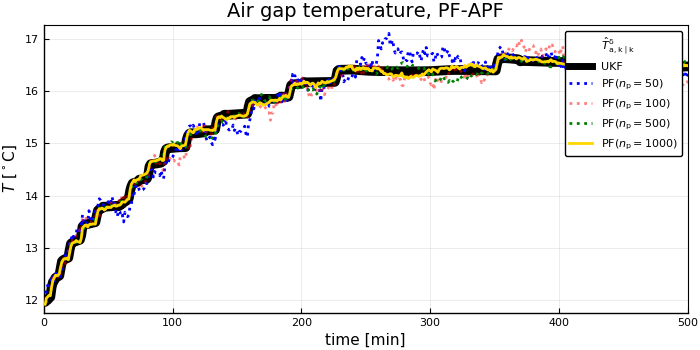

In [442]:
# Comparing PF with different particles for Model 1
# Tr estimate Ris04
plt=plot()
plot!(plt,1,label="\$\\hatT_\\mathrm{r,k\\mid k}\$ Model 1",lc=:white)
plot!(plt,xu_po_UKF[1,:],label="UKF",lc=:black,lw=7,ls=:solid)
plot!(plt,xu_po_PFRis0450[1,:],label="PF(\$n_\\mathrm{p}=50\\mathrm{}\$)",lc=:blue,lw=2,ls=:dot)
plot!(plt,xu_po_PFRis04100[1,:],label="PF(\$n_\\mathrm{p}=100\\mathrm{}\$)",lc=:red,lw=2,la=0.5,ls=:dot)
plot!(plt,xu_po_PFRis04500[1,:],label="PF(\$n_\\mathrm{p}=500\\mathrm{}\$)",lc=:green,lw=2,ls=:dot)
plot!(plt,xu_po_PFRis041000[1,:],label="PF(\$n_\\mathrm{p}=1000\\mathrm{}\$)",lc=:gold,lw=2,ls=:solid)
TrPFRis04 = plot!(plt,xlim=(0,500),size=(700,350),framestyle=:box,title="Rotor copper temperature, PF-Ristic2004",legend=:topright,xlabel="time [min]",ylabel=L"$T$ [${}^\circ$C]")

# Tad estimate Ris04
plt=plot()
plot!(plt,1,label="\$\\hatT_\\mathrm{a,k\\mid k}^\\mathrm{\\delta}\$",lc=:white)
plot!(plt,zu_UKF[1,:],label="UKF",lc=:black,lw=7,ls=:solid)
plot!(plt,zu_PFRis0450[1,:],label="PF(\$n_\\mathrm{p}=50\\mathrm{}\$)",lc=:blue,lw=2,ls=:dot)
plot!(plt,zu_PFRis04100[1,:],label="PF(\$n_\\mathrm{p}=100\\mathrm{}\$)",lc=:red,lw=2,la=0.5,ls=:dot)
plot!(plt,zu_PFRis04500[1,:],label="PF(\$n_\\mathrm{p}=500\\mathrm{}\$)",lc=:green,lw=2,ls=:dot)
plot!(plt,zu_PFRis041000[1,:],label="PF(\$n_\\mathrm{p}=1000\\mathrm{}\$)",lc=:gold,lw=2,ls=:solid)
TadPFRis04 = plot!(plt,xlim=(0,500),size=(700,350),framestyle=:box,title="Air gap temperature, PF-Ristic2004",legend=:topright,xlabel="time [min]",ylabel=L"$T$ [${}^\circ$C]")


# Tr estimate multinomial
plt=plot()
plot!(plt,1,label="\$\\hatT_\\mathrm{r,k\\mid k}\$ Model 1",lc=:white)
plot!(plt,xu_po_UKF[1,:],label="UKF",lc=:black,lw=7,ls=:solid)
plot!(plt,xu_po_PFmultinomial50[1,:],label="PF(\$n_\\mathrm{p}=50\\mathrm{}\$)",lc=:blue,lw=2,ls=:dot)
plot!(plt,xu_po_PFmultinomial100[1,:],label="PF(\$n_\\mathrm{p}=100\\mathrm{}\$)",lc=:red,lw=2,la=0.5,ls=:dot)
plot!(plt,xu_po_PFmultinomial500[1,:],label="PF(\$n_\\mathrm{p}=500\\mathrm{}\$)",lc=:green,lw=2,ls=:dot)
plot!(plt,xu_po_PFmultinomial1000[1,:],label="PF(\$n_\\mathrm{p}=1000\\mathrm{}\$)",lc=:gold,lw=2,ls=:solid)
TrPFmultinomial = plot!(plt,xlim=(0,500),size=(700,350),framestyle=:box,title="Rotor copper temperature, PF-multinomial",legend=:topright,xlabel="time [min]",ylabel=L"$T$ [${}^\circ$C]")

# Tad estimate multinomial
plt=plot()
plot!(plt,1,label="\$\\hatT_\\mathrm{a,k\\mid k}^\\mathrm{\\delta}\$",lc=:white)
plot!(plt,zu_UKF[1,:],label="UKF",lc=:black,lw=7,ls=:solid)
plot!(plt,zu_PFmultinomial50[1,:],label="PF(\$n_\\mathrm{p}=50\\mathrm{}\$)",lc=:blue,lw=2,ls=:dot)
plot!(plt,zu_PFmultinomial100[1,:],label="PF(\$n_\\mathrm{p}=100\\mathrm{}\$)",lc=:red,lw=2,la=0.5,ls=:dot)
plot!(plt,zu_PFmultinomial500[1,:],label="PF(\$n_\\mathrm{p}=500\\mathrm{}\$)",lc=:green,lw=2,ls=:dot)
plot!(plt,zu_PFmultinomial1000[1,:],label="PF(\$n_\\mathrm{p}=1000\\mathrm{}\$)",lc=:gold,lw=2,ls=:solid)
TadPFmultinomial = plot!(plt,xlim=(0,500),size=(700,350),framestyle=:box,title="Air gap temperature, PF-multinomial",legend=:topright,xlabel="time [min]",ylabel=L"$T$ [${}^\circ$C]")

# Tr estimate systematic
plt=plot()
plot!(plt,1,label="\$\\hatT_\\mathrm{r,k\\mid k}\$ Model 1",lc=:white)
plot!(plt,xu_po_UKF[1,:],label="UKF",lc=:black,lw=7,ls=:solid)
plot!(plt,xu_po_PFsystematic50[1,:],label="PF(\$n_\\mathrm{p}=50\\mathrm{}\$)",lc=:blue,lw=2,ls=:dot)
plot!(plt,xu_po_PFsystematic100[1,:],label="PF(\$n_\\mathrm{p}=100\\mathrm{}\$)",lc=:red,lw=2,la=0.5,ls=:dot)
plot!(plt,xu_po_PFsystematic500[1,:],label="PF(\$n_\\mathrm{p}=500\\mathrm{}\$)",lc=:green,lw=2,ls=:dot)
plot!(plt,xu_po_PFsystematic1000[1,:],label="PF(\$n_\\mathrm{p}=1000\\mathrm{}\$)",lc=:gold,lw=2,ls=:solid)
TrPFsystematic = plot!(plt,xlim=(0,500),size=(700,350),framestyle=:box,title="Rotor copper temperature, PF-systematic",legend=:topright,xlabel="time [min]",ylabel=L"$T$ [${}^\circ$C]")

# Tad estimate systematic
plt=plot()
plot!(plt,1,label="\$\\hatT_\\mathrm{a,k\\mid k}^\\mathrm{\\delta}\$",lc=:white)
plot!(plt,zu_UKF[1,:],label="UKF",lc=:black,lw=7,ls=:solid)
plot!(plt,zu_PFsystematic50[1,:],label="PF(\$n_\\mathrm{p}=50\\mathrm{}\$)",lc=:blue,lw=2,ls=:dot)
plot!(plt,zu_PFsystematic100[1,:],label="PF(\$n_\\mathrm{p}=100\\mathrm{}\$)",lc=:red,lw=2,la=0.5,ls=:dot)
plot!(plt,zu_PFsystematic500[1,:],label="PF(\$n_\\mathrm{p}=500\\mathrm{}\$)",lc=:green,lw=2,ls=:dot)
plot!(plt,zu_PFsystematic1000[1,:],label="PF(\$n_\\mathrm{p}=1000\\mathrm{}\$)",lc=:gold,lw=2,ls=:solid)
TadPFsystematic = plot!(plt,xlim=(0,500),size=(700,350),framestyle=:box,title="Air gap temperature, PF-systematic",legend=:topright,xlabel="time [min]",ylabel=L"$T$ [${}^\circ$C]")

# Tr estimate stratified
plt=plot()
plot!(plt,1,label="\$\\hatT_\\mathrm{r,k\\mid k}\$ Model 1",lc=:white)
plot!(plt,xu_po_UKF[1,:],label="UKF",lc=:black,lw=7,ls=:solid)
plot!(plt,xu_po_PFstratified50[1,:],label="PF(\$n_\\mathrm{p}=50\\mathrm{}\$)",lc=:blue,lw=2,ls=:dot)
plot!(plt,xu_po_PFstratified100[1,:],label="PF(\$n_\\mathrm{p}=100\\mathrm{}\$)",lc=:red,lw=2,la=0.5,ls=:dot)
plot!(plt,xu_po_PFstratified500[1,:],label="PF(\$n_\\mathrm{p}=500\\mathrm{}\$)",lc=:green,lw=2,ls=:dot)
plot!(plt,xu_po_PFstratified1000[1,:],label="PF(\$n_\\mathrm{p}=1000\\mathrm{}\$)",lc=:gold,lw=2,ls=:solid)
TrPFstratified = plot!(plt,xlim=(0,500),size=(700,350),framestyle=:box,title="Rotor copper temperature, PF-stratified",legend=:topright,xlabel="time [min]",ylabel=L"$T$ [${}^\circ$C]")

# Tad estimate stratified
plt=plot()
plot!(plt,1,label="\$\\hatT_\\mathrm{a,k\\mid k}^\\mathrm{\\delta}\$",lc=:white)
plot!(plt,zu_UKF[1,:],label="UKF",lc=:black,lw=7,ls=:solid)
plot!(plt,zu_PFstratified50[1,:],label="PF(\$n_\\mathrm{p}=50\\mathrm{}\$)",lc=:blue,lw=2,ls=:dot)
plot!(plt,zu_PFstratified100[1,:],label="PF(\$n_\\mathrm{p}=100\\mathrm{}\$)",lc=:red,lw=2,la=0.5,ls=:dot)
plot!(plt,zu_PFstratified500[1,:],label="PF(\$n_\\mathrm{p}=500\\mathrm{}\$)",lc=:green,lw=2,ls=:dot)
plot!(plt,zu_PFstratified1000[1,:],label="PF(\$n_\\mathrm{p}=1000\\mathrm{}\$)",lc=:gold,lw=2,ls=:solid)
TadPFstratified = plot!(plt,xlim=(0,500),size=(700,350),framestyle=:box,title="Air gap temperature, PF-stratified",legend=:topright,xlabel="time [min]",ylabel=L"$T$ [${}^\circ$C]")

# Tr estimate residual
plt=plot()
plot!(plt,1,label="\$\\hatT_\\mathrm{r,k\\mid k}\$ Model 1",lc=:white)
plot!(plt,xu_po_UKF[1,:],label="UKF",lc=:black,lw=7,ls=:solid)
plot!(plt,xu_po_PFresidual50[1,:],label="PF(\$n_\\mathrm{p}=50\\mathrm{}\$)",lc=:blue,lw=2,ls=:dot)
plot!(plt,xu_po_PFresidual100[1,:],label="PF(\$n_\\mathrm{p}=100\\mathrm{}\$)",lc=:red,lw=2,la=0.5,ls=:dot)
plot!(plt,xu_po_PFresidual500[1,:],label="PF(\$n_\\mathrm{p}=500\\mathrm{}\$)",lc=:green,lw=2,ls=:dot)
plot!(plt,xu_po_PFresidual1000[1,:],label="PF(\$n_\\mathrm{p}=1000\\mathrm{}\$)",lc=:gold,lw=2,ls=:solid)
TrPFresidual = plot!(plt,xlim=(0,500),size=(700,350),framestyle=:box,title="Rotor copper temperature, PF-residual",legend=:topright,xlabel="time [min]",ylabel=L"$T$ [${}^\circ$C]")

# Tad estimate residual
plt=plot()
plot!(plt,1,label="\$\\hatT_\\mathrm{a,k\\mid k}^\\mathrm{\\delta}\$",lc=:white)
plot!(plt,zu_UKF[1,:],label="UKF",lc=:black,lw=7,ls=:solid)
plot!(plt,zu_PFresidual50[1,:],label="PF(\$n_\\mathrm{p}=50\\mathrm{}\$)",lc=:blue,lw=2,ls=:dot)
plot!(plt,zu_PFresidual100[1,:],label="PF(\$n_\\mathrm{p}=100\\mathrm{}\$)",lc=:red,lw=2,la=0.5,ls=:dot)
plot!(plt,zu_PFresidual500[1,:],label="PF(\$n_\\mathrm{p}=500\\mathrm{}\$)",lc=:green,lw=2,ls=:dot)
plot!(plt,zu_PFresidual1000[1,:],label="PF(\$n_\\mathrm{p}=1000\\mathrm{}\$)",lc=:gold,lw=2,ls=:solid)
TadPFresidual = plot!(plt,xlim=(0,500),size=(700,350),framestyle=:box,title="Air gap temperature, PF-residual",legend=:topright,xlabel="time [min]",ylabel=L"$T$ [${}^\circ$C]")

# Tr estimate RPF
plt=plot()
plot!(plt,1,label="\$\\hatT_\\mathrm{r,k\\mid k}\$ Model 1",lc=:white)
plot!(plt,xu_po_UKF[1,:],label="UKF",lc=:black,lw=7,ls=:solid)
plot!(plt,xu_po_PFRPF50[1,:],label="PF(\$n_\\mathrm{p}=50\\mathrm{}\$)",lc=:blue,lw=2,ls=:dot)
plot!(plt,xu_po_PFRPF100[1,:],label="PF(\$n_\\mathrm{p}=100\\mathrm{}\$)",lc=:red,lw=2,la=0.5,ls=:dot)
plot!(plt,xu_po_PFRPF500[1,:],label="PF(\$n_\\mathrm{p}=500\\mathrm{}\$)",lc=:green,lw=2,ls=:dot)
plot!(plt,xu_po_PFRPF1000[1,:],label="PF(\$n_\\mathrm{p}=1000\\mathrm{}\$)",lc=:gold,lw=2,ls=:solid)
TrPFRPF = plot!(plt,xlim=(0,500),size=(700,350),framestyle=:box,title="Rotor copper temperature, PF-RPF",legend=:topright,xlabel="time [min]",ylabel=L"$T$ [${}^\circ$C]")

# Tad estimate RPF
plt=plot()
plot!(plt,1,label="\$\\hatT_\\mathrm{a,k\\mid k}^\\mathrm{\\delta}\$",lc=:white)
plot!(plt,zu_UKF[1,:],label="UKF",lc=:black,lw=7,ls=:solid)
plot!(plt,zu_PFRPF50[1,:],label="PF(\$n_\\mathrm{p}=50\\mathrm{}\$)",lc=:blue,lw=2,ls=:dot)
plot!(plt,zu_PFRPF100[1,:],label="PF(\$n_\\mathrm{p}=100\\mathrm{}\$)",lc=:red,lw=2,la=0.5,ls=:dot)
plot!(plt,zu_PFRPF500[1,:],label="PF(\$n_\\mathrm{p}=500\\mathrm{}\$)",lc=:green,lw=2,ls=:dot)
plot!(plt,zu_PFRPF1000[1,:],label="PF(\$n_\\mathrm{p}=1000\\mathrm{}\$)",lc=:gold,lw=2,ls=:solid)
TadPFRPF = plot!(plt,xlim=(0,500),size=(700,350),framestyle=:box,title="Air gap temperature, PF-RPF",legend=:topright,xlabel="time [min]",ylabel=L"$T$ [${}^\circ$C]")

# Tr estimate APF
plt=plot()
plot!(plt,1,label="\$\\hatT_\\mathrm{r,k\\mid k}\$ Model 1",lc=:white)
plot!(plt,xu_po_UKF[1,:],label="UKF",lc=:black,lw=7,ls=:solid)
plot!(plt,xu_po_PFAPF50[1,:],label="PF(\$n_\\mathrm{p}=50\\mathrm{}\$)",lc=:blue,lw=2,ls=:dot)
plot!(plt,xu_po_PFAPF100[1,:],label="PF(\$n_\\mathrm{p}=100\\mathrm{}\$)",lc=:red,lw=2,la=0.5,ls=:dot)
plot!(plt,xu_po_PFAPF500[1,:],label="PF(\$n_\\mathrm{p}=500\\mathrm{}\$)",lc=:green,lw=2,ls=:dot)
plot!(plt,xu_po_PFAPF1000[1,:],label="PF(\$n_\\mathrm{p}=1000\\mathrm{}\$)",lc=:gold,lw=2,ls=:solid)
TAPF = plot!(plt,xlim=(0,500),size=(700,350),framestyle=:box,title="Rotor copper temperature, PF-APF",legend=:topright,xlabel="time [min]",ylabel=L"$T$ [${}^\circ$C]")

# Tad estimate APF
plt=plot()
plot!(plt,1,label="\$\\hatT_\\mathrm{a,k\\mid k}^\\mathrm{\\delta}\$",lc=:white)
plot!(plt,zu_UKF[1,:],label="UKF",lc=:black,lw=7,ls=:solid)
plot!(plt,zu_PFAPF50[1,:],label="PF(\$n_\\mathrm{p}=50\\mathrm{}\$)",lc=:blue,lw=2,ls=:dot)
plot!(plt,zu_PFAPF100[1,:],label="PF(\$n_\\mathrm{p}=100\\mathrm{}\$)",lc=:red,lw=2,la=0.5,ls=:dot)
plot!(plt,zu_PFAPF500[1,:],label="PF(\$n_\\mathrm{p}=500\\mathrm{}\$)",lc=:green,lw=2,ls=:dot)
plot!(plt,zu_PFAPF1000[1,:],label="PF(\$n_\\mathrm{p}=1000\\mathrm{}\$)",lc=:gold,lw=2,ls=:solid)
TadPFAPF = plot!(plt,xlim=(0,500),size=(700,350),framestyle=:box,title="Air gap temperature, PF-APF",legend=:topright,xlabel="time [min]",ylabel=L"$T$ [${}^\circ$C]")

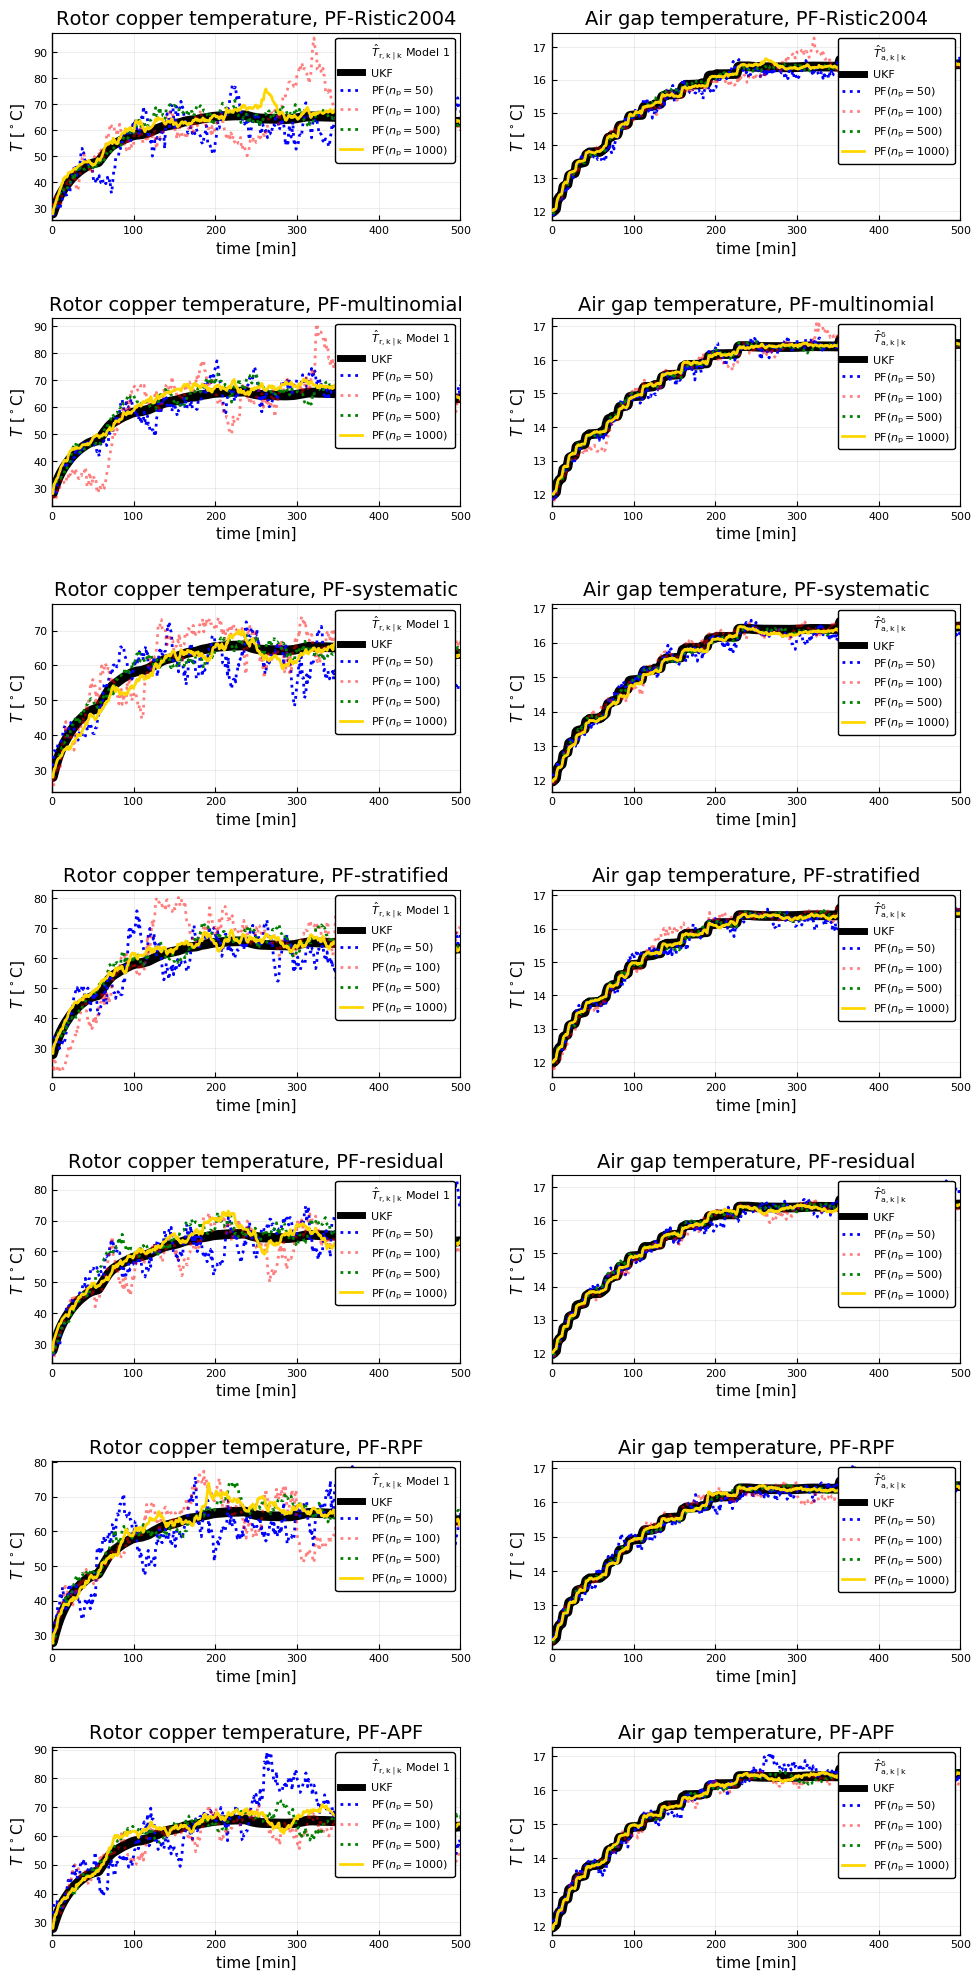

In [444]:
# Plotting for SummerJob2019
figpath = "C:/Users/pande/Desktop/Desktop/SummerJob2019/Figures/Resampling/";
using Plots.PlotMeasures
pyplot();
resamplingComparison=plot(TrPFRis04,TadPFRis04,TrPFmultinomial,TadPFmultinomial,TrPFsystematic,TadPFsystematic,
    TrPFstratified,TadPFstratified,TrPFresidual,TadPFresidual,TrPFRPF,TadPFRPF,TrPFAPF,TadPFAPF,
        layout=grid(7,2),size = (1000, 2000),framestyle = :box,
        bottom_margin=10mm,right_margin=10mm,legend=:topright)
figfile="UKFPFTrTad.svg"
savefig(figpath*figfile)

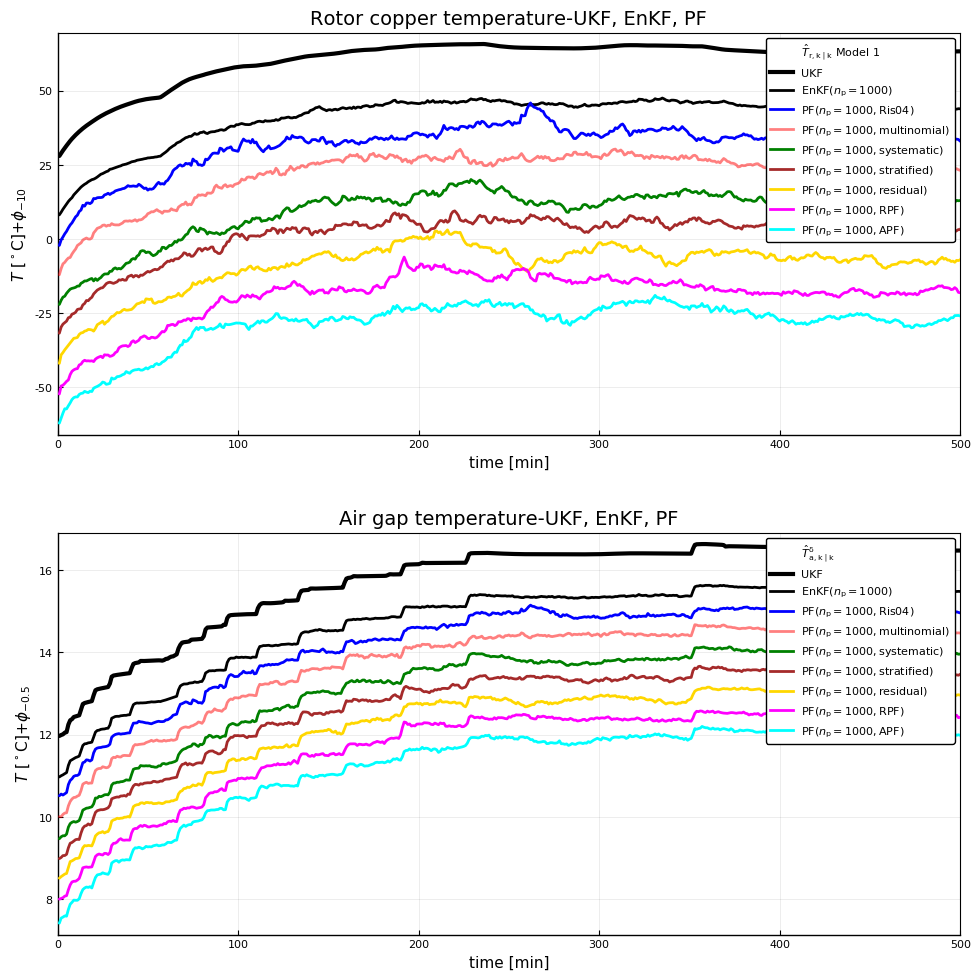

In [445]:
# Comparison of EnKF and Particle filter
# Tr estimate Ris04
phase=10
plt=plot()
plot!(plt,1,label="\$\\hatT_\\mathrm{r,k\\mid k}\$ Model 1",lc=:white)
plot!(plt,xu_po_UKF[1,:].-phase*0,label="UKF",lc=:black,lw=3,ls=:solid)
plot!(plt,xu_po_EnKF1000[1,:].-phase*2,label="EnKF(\$n_\\mathrm{p}=1000\\mathrm{}\$)",lc=:black,lw=2,ls=:solid)
plot!(plt,xu_po_PFRis041000[1,:].-phase*3,label="PF(\$n_\\mathrm{p}=1000,\\mathrm{Ris04}\$)",lc=:blue,lw=2,ls=:solid)
plot!(plt,xu_po_PFmultinomial1000[1,:].-phase*4,label="PF(\$n_\\mathrm{p}=1000,\\mathrm{multinomial}\$)",lc=:red,lw=2,la=0.5,ls=:solid)
plot!(plt,xu_po_PFsystematic1000[1,:].-phase*5,label="PF(\$n_\\mathrm{p}=1000,\\mathrm{systematic}\$)",lc=:green,lw=2,ls=:solid)
plot!(plt,xu_po_PFstratified1000[1,:].-phase*6,label="PF(\$n_\\mathrm{p}=1000,\\mathrm{stratified}\$)",lc=:brown,lw=2,ls=:solid)
plot!(plt,xu_po_PFresidual1000[1,:].-phase*7,label="PF(\$n_\\mathrm{p}=1000,\\mathrm{residual}\$)",lc=:gold,lw=2,ls=:solid)
plot!(plt,xu_po_PFRPF1000[1,:].-phase*8,label="PF(\$n_\\mathrm{p}=1000,\\mathrm{RPF}\$)",lc=:magenta,lw=2,ls=:solid)
plot!(plt,xu_po_PFAPF1000[1,:].-phase*9,label="PF(\$n_\\mathrm{p}=1000,\\mathrm{APF}\$)",lc=:cyan,lw=2,ls=:solid)
TrUKFEnKFPF = plot!(plt,xlim=(0,500),size=(700,350),framestyle=:box,title="Rotor copper temperature-UKF, EnKF, PF",legend=:topright,xlabel="time [min]",ylabel=L"$T$ [${}^\circ$C]+$\phi_\mathrm{-10}$")
phase = 0.5
# Tad estimate Ris04
plt=plot()
plot!(plt,1,label="\$\\hatT_\\mathrm{a,k\\mid k}^\\mathrm{\\delta}\$",lc=:white)
plot!(plt,zu_UKF[1,:].-phase*0,label="UKF",lc=:black,lw=3,ls=:solid)
plot!(plt,zu_EnKF1000[1,:].-phase*2,label="EnKF(\$n_\\mathrm{p}=1000\\mathrm{}\$)",lc=:black,lw=2,ls=:solid)
plot!(plt,zu_PFRis041000[1,:].-phase*3,label="PF(\$n_\\mathrm{p}=1000,\\mathrm{Ris04}\$)",lc=:blue,lw=2,ls=:solid)
plot!(plt,zu_PFmultinomial1000[1,:].-phase*4,label="PF(\$n_\\mathrm{p}=1000,\\mathrm{multinomial}\$)",lc=:red,lw=2,la=0.5,ls=:solid)
plot!(plt,zu_PFsystematic1000[1,:].-phase*5,label="PF(\$n_\\mathrm{p}=1000,\\mathrm{systematic}\$)",lc=:green,lw=2,ls=:solid)
plot!(plt,zu_PFstratified1000[1,:].-phase*6,label="PF(\$n_\\mathrm{p}=1000,\\mathrm{stratified}\$)",lc=:brown,lw=2,ls=:solid)
plot!(plt,zu_PFresidual1000[1,:].-phase*7,label="PF(\$n_\\mathrm{p}=1000,\\mathrm{residual}\$)",lc=:gold,lw=2,ls=:solid)
plot!(plt,zu_PFRPF1000[1,:].-phase*8,label="PF(\$n_\\mathrm{p}=1000,\\mathrm{RPF}\$)",lc=:magenta,lw=2,ls=:solid)
plot!(plt,zu_PFAPF1000[1,:].-phase*9,label="PF(\$n_\\mathrm{p}=1000,\\mathrm{APF}\$)",lc=:cyan,lw=2,ls=:solid)
TadUKFEnKFPF = plot!(plt,xlim=(0,500),size=(700,350),framestyle=:box,title="Air gap temperature-UKF, EnKF, PF",legend=:topright,xlabel="time [min]",ylabel=L"$T$ [${}^\circ$C]+$\phi_\mathrm{-0.5}$")

# Plotting for SummerJob2019
figpath = "C:/Users/pande/Desktop/Desktop/SummerJob2019/Figures/Resampling/";
using Plots.PlotMeasures
pyplot();
resamplingComparison=plot(TrUKFEnKFPF,TadUKFEnKFPF,
        layout=grid(2,1),size = (1000, 1000),framestyle = :box,
        bottom_margin=10mm,right_margin=10mm,legend=:topright)
figfile="UKFPFEnKF.svg"
savefig(figpath*figfile)


In [21]:
# Comparing filters with estimation accuracy and computational time.

# Estimation accuracy
# Calculating residual e
y_m = [[Ts_m[i],TFe_m[i]] for i in 1:N];
# e of UKF
e_UKF = sqrt(sum((yu_pr_UKF'-hcat(y_m...)').^2)/N)

2.215247813062839

In [22]:
# e of EnKF
e_EnKF=zeros(4)
# Residual (ymeas-yhat)
e_EnKF[1]=sqrt(sum((yu_pr_EnKF50'-hcat(y_m...)').^2)/N)
e_EnKF[2]=sqrt(sum((yu_pr_EnKF100'-hcat(y_m...)').^2)/N)
e_EnKF[3]=sqrt(sum((yu_pr_EnKF500'-hcat(y_m...)').^2)/N)
e_EnKF[4]=sqrt(sum((yu_pr_EnKF1000'-hcat(y_m...)').^2)/N)
e_EnKF

4-element Array{Float64,1}:
 2.090556576113383 
 2.0427973946222187
 2.0183610382758324
 2.0101438516937056

In [23]:
# e of PFRis04
e_PFRis04=zeros(4)
# Residual (ymeas-yhat)
e_PFRis04[1]=sqrt(sum((yu_pr_PFRis0450'-hcat(y_m...)').^2)/N)
e_PFRis04[2]=sqrt(sum((yu_pr_PFRis04100'-hcat(y_m...)').^2)/N)
e_PFRis04[3]=sqrt(sum((yu_pr_PFRis04500'-hcat(y_m...)').^2)/N)
e_PFRis04[4]=sqrt(sum((yu_pr_PFRis041000'-hcat(y_m...)').^2)/N)
e_PFRis04

4-element Array{Float64,1}:
 2.233603038455804 
 2.1475460556471333
 2.114996996616755 
 2.131035668539848 

In [25]:
# e of PFmultinomial
e_PFmultinomial=zeros(4)
# Residual (ymeas-yhat)
e_PFmultinomial[1]=sqrt(sum((yu_pr_PFmultinomial50'-hcat(y_m...)').^2)/N)
e_PFmultinomial[2]=sqrt(sum((yu_pr_PFmultinomial100'-hcat(y_m...)').^2)/N)
e_PFmultinomial[3]=sqrt(sum((yu_pr_PFmultinomial500'-hcat(y_m...)').^2)/N)
e_PFmultinomial[4]=sqrt(sum((yu_pr_PFmultinomial1000'-hcat(y_m...)').^2)/N)
e_PFmultinomial

4-element Array{Float64,1}:
 2.223002264158176 
 2.169091864982749 
 2.1235044889222148
 2.123769014176593 

In [26]:
# e of PFsystematic
e_PFsystematic=zeros(4)
# Residual (ymeas-yhat)
e_PFsystematic[1]=sqrt(sum((yu_pr_PFsystematic50'-hcat(y_m...)').^2)/N)
e_PFsystematic[2]=sqrt(sum((yu_pr_PFsystematic100'-hcat(y_m...)').^2)/N)
e_PFsystematic[3]=sqrt(sum((yu_pr_PFsystematic500'-hcat(y_m...)').^2)/N)
e_PFsystematic[4]=sqrt(sum((yu_pr_PFsystematic1000'-hcat(y_m...)').^2)/N)
e_PFsystematic

4-element Array{Float64,1}:
 2.2444770586966105
 2.15639160480666  
 2.126635223083542 
 2.136259747160602 

In [27]:
# e of PFstratified
e_PFstratified=zeros(4)
# Residual (ymeas-yhat)
e_PFstratified[1]=sqrt(sum((yu_pr_PFstratified50'-hcat(y_m...)').^2)/N)
e_PFstratified[2]=sqrt(sum((yu_pr_PFstratified100'-hcat(y_m...)').^2)/N)
e_PFstratified[3]=sqrt(sum((yu_pr_PFstratified500'-hcat(y_m...)').^2)/N)
e_PFstratified[4]=sqrt(sum((yu_pr_PFstratified1000'-hcat(y_m...)').^2)/N)
e_PFstratified

4-element Array{Float64,1}:
 2.2268495020221613
 2.157831719604404 
 2.126834955119944 
 2.1190044795110543

In [28]:
# e of PFresidual
e_PFresidual=zeros(4)
# Residual (ymeas-yhat)
e_PFresidual[1]=sqrt(sum((yu_pr_PFresidual50'-hcat(y_m...)').^2)/N)
e_PFresidual[2]=sqrt(sum((yu_pr_PFresidual100'-hcat(y_m...)').^2)/N)
e_PFresidual[3]=sqrt(sum((yu_pr_PFresidual500'-hcat(y_m...)').^2)/N)
e_PFresidual[4]=sqrt(sum((yu_pr_PFresidual1000'-hcat(y_m...)').^2)/N)
e_PFresidual

4-element Array{Float64,1}:
 2.2044534157796165
 2.182716865993502 
 2.1247859985721167
 2.12620460369034  

In [29]:
# e of PFRPF
e_PFRPF=zeros(4)
# RPF (ymeas-yhat)
e_PFRPF[1]=sqrt(sum((yu_pr_PFRPF50'-hcat(y_m...)').^2)/N)
e_PFRPF[2]=sqrt(sum((yu_pr_PFRPF100'-hcat(y_m...)').^2)/N)
e_PFRPF[3]=sqrt(sum((yu_pr_PFRPF500'-hcat(y_m...)').^2)/N)
e_PFRPF[4]=sqrt(sum((yu_pr_PFRPF1000'-hcat(y_m...)').^2)/N)
e_PFRPF

4-element Array{Float64,1}:
 2.2485113087017345
 2.1389699620026104
 2.1300250316407605
 2.1250663682984157

In [30]:
# e of PFAPF
e_PFAPF=zeros(4)
# APF (ymeas-yhat)
e_PFAPF[1]=sqrt(sum((yu_pr_PFAPF50'-hcat(y_m...)').^2)/N)
e_PFAPF[2]=sqrt(sum((yu_pr_PFAPF100'-hcat(y_m...)').^2)/N)
e_PFAPF[3]=sqrt(sum((yu_pr_PFAPF500'-hcat(y_m...)').^2)/N)
e_PFAPF[4]=sqrt(sum((yu_pr_PFAPF1000'-hcat(y_m...)').^2)/N)
e_PFAPF

4-element Array{Float64,1}:
 2.213870673782579 
 2.1568681060798114
 2.138409810317328 
 2.1212050599019845

In [21]:
# Computational time
# Computing computational time
N = 10
time_UKF=zeros(1000)
for i in 1:1000
    time_UKF[i]=@elapsed UKF()
end
comptime_UKF=mean(time_UKF)/N

0.0004731985400000001

In [23]:
# EnKF
time_EnKF = zeros(4,50)
for i in 1:50
    time_EnKF[1,i] = @elapsed EnKF(50)
    time_EnKF[2,i] = @elapsed EnKF(100)
    time_EnKF[3,i] = @elapsed EnKF(500)
    time_EnKF[4,i] = @elapsed EnKF(1000)
end
comptime_EnKF=mean(time_EnKF,dims=2)/N

4×1 Array{Float64,2}:
 0.002579786912      
 0.004700745968000001
 0.021733683603999996
 0.043580955133999996

In [25]:
# PFRis04
time_PFRis04 = zeros(4,50)
for i in 1:50
    time_PFRis04[1,i] = @elapsed PF(50,"Ris04")
    time_PFRis04[2,i] = @elapsed PF(100,"Ris04")
    time_PFRis04[3,i] = @elapsed PF(500,"Ris04")
    time_PFRis04[4,i] = @elapsed PF(1000,"Ris04")
end
comptime_PFRis04=mean(time_PFRis04,dims=2)/N

4×1 Array{Float64,2}:
 0.0021003182380000002
 0.004329871454       
 0.020877338172000007 
 0.043037532944       

In [26]:
# PFmultinominal
time_PFmultinominal = zeros(4,50)
for i in 1:50
    time_PFmultinominal[1,i] = @elapsed PF(50,"multinominal")
    time_PFmultinominal[2,i] = @elapsed PF(100,"multinominal")
    time_PFmultinominal[3,i] = @elapsed PF(500,"multinominal")
    time_PFmultinominal[4,i] = @elapsed PF(1000,"multinominal")
end
comptime_PFmultinominal=mean(time_PFmultinominal,dims=2)/N

4×1 Array{Float64,2}:
 0.002094399202      
 0.004044072938000001
 0.018899184216000002
 0.04011796674399998 

In [27]:
# PFsystematic
time_PFsystematic = zeros(4,50)
for i in 1:50
    time_PFsystematic[1,i] = @elapsed PF(50,"systematic")
    time_PFsystematic[2,i] = @elapsed PF(100,"systematic")
    time_PFsystematic[3,i] = @elapsed PF(500,"systematic")
    time_PFsystematic[4,i] = @elapsed PF(1000,"systematic")
end
comptime_PFsystematic=mean(time_PFsystematic,dims=2)/N

4×1 Array{Float64,2}:
 0.0024581282719999993
 0.004080783938       
 0.019981012256       
 0.040925923899999994 

In [28]:
# PFstratified
time_PFstratified = zeros(4,50)
for i in 1:50
    time_PFstratified[1,i] = @elapsed PF(50,"stratified")
    time_PFstratified[2,i] = @elapsed PF(100,"stratified")
    time_PFstratified[3,i] = @elapsed PF(500,"stratified")
    time_PFstratified[4,i] = @elapsed PF(1000,"stratified")
end
comptime_PFstratified=mean(time_PFstratified,dims=2)/N

4×1 Array{Float64,2}:
 0.0020469277300000006
 0.004073328902       
 0.021534470290000003 
 0.044375978296000027 

In [29]:
# PFresidual
time_PFresidual = zeros(4,50)
for i in 1:50
    time_PFresidual[1,i] = @elapsed PF(50,"residual")
    time_PFresidual[2,i] = @elapsed PF(100,"residual")
    time_PFresidual[3,i] = @elapsed PF(500,"residual")
    time_PFresidual[4,i] = @elapsed PF(1000,"residual")
end
comptime_PFresidual=mean(time_PFresidual,dims=2)/N

4×1 Array{Float64,2}:
 0.0019610830279999996
 0.004086133846       
 0.019856197688000003 
 0.038911582948       

In [30]:
# PFRPF
time_PFRPF = zeros(4,50)
for i in 1:50
    time_PFRPF[1,i] = @elapsed PF(50,"RPF")
    time_PFRPF[2,i] = @elapsed PF(100,"RPF")
    time_PFRPF[3,i] = @elapsed PF(500,"RPF")
    time_PFRPF[4,i] = @elapsed PF(1000,"RPF")
end
comptime_PFRPF=mean(time_PFRPF,dims=2)/N

4×1 Array{Float64,2}:
 0.026780204768     
 0.09492754946400002
 2.152170556796     
 8.362767863866     

In [31]:
# PFAPF
time_PFAPF = zeros(4,50)
for i in 1:50
    time_PFAPF[1,i] = @elapsed PF(50,"APF")
    time_PFAPF[2,i] = @elapsed PF(100,"APF")
    time_PFAPF[3,i] = @elapsed PF(500,"APF")
    time_PFAPF[4,i] = @elapsed PF(1000,"APF")
end
comptime_PFAPF=mean(time_PFAPF,dims=2)/N

4×1 Array{Float64,2}:
 0.0012346905040000002
 0.0026288211820000005
 0.014270291097999996 
 0.027269559422       

In [33]:
@elapsed PF(1000,"RPF")

66.783194608